In [2]:
#initialization - libraries and settings

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas
import geodatasets 
from matplotlib.colors import LogNorm
from tqdm import tqdm #library for progress bars
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import gudhi as gd
from gudhi.representations import PersistenceImage
from sklearn.neighbors import BallTree


# Set figure size for all plots
plt.rcParams['figure.figsize'] = [10, 10]  # width, height in inches

This process is the import procedure for the tetracycline data from the .csv file used to store data uploaded from the literature. The data is cleaned during the upload. Since some information is stored in scientific numerals, it must be converted into floating-point numeration. Removal of the +/- values also takes place here. In order to meet auditing requirements, all processes are documented in the output.

In [5]:
#extract data with specific formatting from CSV file
def extract_number(value, changes):
    original_value = value
    try:
        # Check if the value already a number
        if isinstance(value, (int, float)):
            return value

        # Remove commas from value
        if isinstance(value, str):
            value = value.replace(",", "")

        # scientific notation in the format '5.7±1.1×10^4'
        match = re.match(r"^(.*?)(?:±.*?)?×10\^([\d+-]+)$", value)
        if match:
            base = match.group(1)
            exponent = match.group(2)
            if not base:
                changes.append((original_value, None))  # Record the change
                return None

            new_value = float(base) * (10 ** float(exponent))
            changes.append((original_value, new_value))  # Record the change
            return new_value

        # Handle the '±' format
        if '±' in value:
            num_part = value.split('±')[0]
            new_value = float(num_part)
            changes.append((original_value, new_value))
            return new_value
        else:
            return float(value)

    except (ValueError, TypeError, AttributeError):
        changes.append((original_value, None))  # Record the change
        return None

# Initialize list track changes
changes_made = []

# CSV upload of tetracycline measurements with changes made during import
df_meas = pd.read_csv(r"C:\Users\phosg\OneDrive\Documents\TetEMeasurements_NoFDA_USETHIS.csv", encoding='latin-1', usecols=range(7),
                 converters={'Amount': lambda x: extract_number(x, changes_made)})

# Print audit summary
print("Changes Made During Import:")
print("----------------------------")
if changes_made:
    for original, new in changes_made:
        if new is None:
            print(f"  '{original}' -> Could not parse")
        else:
            print(f"  '{original}' -> {new}")
else:
    print("  No changes made.")

print("\nDataFrame after import:")
print(df_meas)

Changes Made During Import:
----------------------------
  '231±0.08' -> 231.0
  '224±0.07' -> 224.0
  '256±0.05' -> 256.0
  '212±0.034' -> 212.0
  '234±0.075' -> 234.0
  '226±0.032' -> 226.0
  '196±0.065' -> 196.0
  '183±0.021' -> 183.0
  '192±0.031' -> 192.0
  '175±0.021' -> 175.0
  '189±0.010' -> 189.0
  '194±0.031' -> 194.0
  '265±0.015' -> 265.0
  '247±0.021' -> 247.0
  '258±0.011' -> 258.0
  '231±0.09' -> 231.0
  '227±0.066' -> 227.0
  '218±0.050' -> 218.0
  '241±0.044' -> 241.0
  '235±0.005' -> 235.0
  '224±0.002' -> 224.0
  '267±0.016' -> 267.0
  '252±0.014' -> 252.0
  '249±0.002' -> 249.0
  '232±0.012' -> 232.0
  '241±0.022' -> 241.0
  '223±0.001' -> 223.0
  '265±0.013' -> 265.0
  '274±0.001' -> 274.0
  '248±0.014' -> 248.0
  '233±0.010' -> 233.0
  '241±0.070' -> 241.0
  '257±0.107' -> 257.0
  '287±0.032' -> 287.0
  '276±0.064' -> 276.0
  '295±0.062' -> 295.0
  '237±0.054' -> 237.0
  '241±0.027' -> 241.0
  '255±0.069' -> 255.0
  '225±0.063' -> 225.0
  '246±0.037' -> 246.0
  '2

The first ten lines of data in the output format are presented here.

In [8]:
#show data

df_meas.head(10)

,Compartment,Antimicrobial,Amount,Units,Geolocation,Country,Year
0,Tissue,Oxytetracycline,231.0,ppb,Hamadan Province,Iran,2016
1,Tissue,Oxytetracycline,224.0,ppb,Hamadan Province,Iran,2016
2,Tissue,Oxytetracycline,256.0,ppb,Hamadan Province,Iran,2016
3,Tissue,Oxytetracycline,212.0,ppb,Hamadan Province,Iran,2016
4,Tissue,Oxytetracycline,234.0,ppb,Hamadan Province,Iran,2016
5,Tissue,Oxytetracycline,226.0,ppb,Hamadan Province,Iran,2016
6,Tissue,Oxytetracycline,196.0,ppb,Hamadan Province,Iran,2016
7,Tissue,Oxytetracycline,183.0,ppb,Hamadan Province,Iran,2016
8,Tissue,Oxytetracycline,192.0,ppb,Hamadan Province,Iran,2016
9,Tissue,Oxytetracycline,175.0,ppb,Hamadan Province,Iran,2016


To standardize the concentrations, the numbers are converted to nanograms per gram, again with auditing features to indicate where deviations from the expected output might be noted. Each compartment is handled differently, as the original volumes have different characteristics. Tissue concentrations have an assumed density, aquatic concentrations have a liquid component and assume a density of water, and sedimentary concentrations are an approximation, as dry and wet weight factors will not be taken into account.

In [11]:
# Convert amounts to ng/g and provide audit log

# Initialize list for track conversion changes
conversion_changes = []

# Define conversion function
def convert_to_ng_g(row):
    original_amount = row['Amount']
    original_unit = row['Units']
    compartment = row['Compartment']
    converted_amount = original_amount # Default to original amount
    converted_unit = 'ng/g' # Target unit

    change_made = False
    warning_note = None # add specific assumption warnings to log

    # Handle NaN or non-numeric amounts before conversion
    if pd.isna(original_amount) or not isinstance(original_amount, (int, float)):
         log_entry = {
            'Original Amount': original_amount, 'Original Unit': original_unit, 'Compartment': compartment,
            'Converted Amount': 'Error/Invalid Input Amount', 'Converted Unit': 'N/A', 'Note': 'Invalid input' }
         conversion_changes.append(log_entry)
         return pd.Series([np.nan, None]) # Return NaN for amount, None for unit

    # Tissue Conversions (Assuming density 1 g/mL = 1 g/g for ppb)
    if compartment == 'Tissue':
        if original_unit == 'ppb':
            # 1 ppb = 1 ng/mL = 1 ng/g (assuming density 1 g/mL)
            converted_amount = original_amount
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/kg':
            # 1 ug/kg = 1000 ng / 1000 g = 1 ng/g
            converted_amount = original_amount
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/g': # <<<--- ADDED THIS CASE for Tissue
             # 1 ug/g = 1000 ng / 1 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/g':
             converted_amount = original_amount # Already correct
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Tissue compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    # Aquatic Conversions (Assuming density 1 kg/L for L units)
    elif compartment == 'Aquatic':
        if original_unit == 'ng/L':
            # 1 ng/L = 1 ng / 1000 g = 0.001 ng/g
            converted_amount = original_amount * 0.001
            if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/L':
             # 1 ug/L = 1000 ng / 1000 g = 1 ng/g
             converted_amount = original_amount
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'mg/L':
             # 1 mg/L = 1,000,000 ng / 1000 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/g':
             converted_amount = original_amount # Already correct
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Aquatic compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    # Sediment Conversions (Assuming density 1 kg/L for ng/L unit)
    elif compartment == 'Sediment':
        if original_unit == 'ng/g':
            converted_amount = original_amount # Already correct
        elif original_unit == 'mg/kg':
             # 1 mg/kg = 1,000,000 ng / 1000 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/kg':
             # 1 ug/kg = 1000 ng / 1000 g = 1 ng/g
             converted_amount = original_amount
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/kg':
             # 1 ng/kg = 1 ng / 1000 g = 0.001 ng/g
             converted_amount = original_amount * 0.001
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ng/L': # for Sediment
             # 1 ng/L = 1 ng / 1000 g = 0.001 ng/g (ASSUMES DENSITY 1 kg/L for measurement context)
             converted_amount = original_amount * 0.001
             warning_note = "Assumed 1 kg/L density for ng/L to ng/g conversion"
             print(f"Note: Applied 0.001 factor for ng/L in Sediment (Row Index: {row.name}), assuming density 1 kg/L.") # Print note during run
             if original_unit != converted_unit: change_made = True
        elif original_unit == 'ug/g': # for Sediment
             # 1 ug/g = 1000 ng / 1 g = 1000 ng/g
             converted_amount = original_amount * 1000
             if original_unit != converted_unit: change_made = True
        else:
             print(f"Warning: Unit '{original_unit}' not explicitly handled for Sediment compartment.")
             converted_amount = np.nan
             converted_unit = None
             change_made = True
             warning_note = f"Unhandled unit '{original_unit}'"

    else:
         print(f"Warning: Compartment '{compartment}' not recognized.")
         converted_amount = np.nan
         converted_unit = None
         change_made = True
         warning_note = f"Unrecognized compartment '{compartment}'"

    # Log change/error status
    log_entry = {
            'Original Amount': original_amount, 'Original Unit': original_unit, 'Compartment': compartment,
            'Converted Amount': converted_amount if not pd.isna(converted_amount) else 'Error/Unhandled/Invalid',
            'Converted Unit': converted_unit if converted_unit is not None else 'N/A',
            'Note': warning_note if warning_note else '' # Add note if applicable
        }
    # Log only if change was made or an error/warning occurred
    if change_made or (original_unit != converted_unit and converted_unit == 'ng/g'):
        conversion_changes.append(log_entry)

    # Return NaN for amount if None or NaN during conversion
    final_amount = converted_amount if not pd.isna(converted_amount) else np.nan
    final_unit = converted_unit if converted_unit is not None else None

    return pd.Series([final_amount, final_unit])


# conversion function
df_meas[['Amount_ng_g', 'Units_ng_g']] = df_meas.apply(convert_to_ng_g, axis=1)

# Audit Log
print("\nUnit Conversions Log:")
print("----------------------")
if conversion_changes:
    df_changes = pd.DataFrame(conversion_changes)
    df_changes['Converted Amount'] = pd.to_numeric(df_changes['Converted Amount'], errors='coerce').fillna(df_changes['Converted Amount']) # Keep strings for errors

    # Filter successful and error logs
    df_success = df_changes[~df_changes['Converted Amount'].astype(str).str.contains('Error/Unhandled/Invalid', na=False)]
    df_errors = df_changes[df_changes['Converted Amount'].astype(str).str.contains('Error/Unhandled/Invalid', na=False)]

    print(f"Total rows processed where logging occurred: {len(df_changes)}")
    print(f"  Successfully converted/relabeled: {len(df_success)}")
    print(f"  Errors or unhandled units/compartments/invalid input: {len(df_errors)}")

    # Display sample of successful conversions
    if not df_success.empty:
        print("\nSample of successful conversions/relabelings (first 10):")
        # Select columns in log, including Note
        print(df_success[['Original Amount', 'Original Unit', 'Compartment', 'Converted Amount', 'Converted Unit', 'Note']].head(10).to_markdown(index=False))
    # Display a sample of errors
    if not df_errors.empty:
         print("\nSample of errors/unhandled/invalid (first 10):")
         print(df_errors[['Original Amount', 'Original Unit', 'Compartment', 'Converted Amount', 'Converted Unit', 'Note']].head(10).to_markdown(index=False))

else:
    print("  No unit conversions or issues were logged.")

print("\nDataFrame after unit conversion (first 5 rows):")
# Display head with new columns, ensuring Amount_ng_g include
print(df_meas[['Compartment', 'Antimicrobial', 'Amount', 'Units', 'Amount_ng_g', 'Units_ng_g', 'Geolocation', 'Country', 'Year']].head().to_markdown(index=False))

# Check for remaining nulls (NaN) in new amount column
print(f"\nNaN values in 'Amount_ng_g' after conversion: {df_meas['Amount_ng_g'].isnull().sum()}")

Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 625), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 626), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 627), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 628), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 629), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 630), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 631), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 632), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 633), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 634), assuming density 1 kg/L.
Note: Applied 0.001 factor for ng/L in Sediment (Row Index: 635), assuming density 1 kg/L.

Statistics of the dataset.

In [14]:
# statistical makeup of TC measurements
print(df_meas.describe())

             Amount         Year    Amount_ng_g
count  1.714000e+03  1714.000000    1714.000000
mean   5.122365e+03  2007.568845     422.641478
std    8.826796e+04     7.426400    8351.611809
min    0.000000e+00  1987.000000       0.000000
25%    0.000000e+00  1999.000000       0.000000
50%    0.000000e+00  2009.000000       0.000000
75%    2.000000e+01  2013.000000       0.287500
max    2.400000e+06  2021.000000  285000.000000


Variable makeup of the data.These are the categories of the dataset.

In [17]:
#variables in dataset
print(df_meas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Compartment    1714 non-null   object 
 1   Antimicrobial  1714 non-null   object 
 2   Amount         1714 non-null   float64
 3   Units          1714 non-null   object 
 4   Geolocation    1714 non-null   object 
 5   Country        1714 non-null   object 
 6   Year           1714 non-null   int64  
 7   Amount_ng_g    1714 non-null   float64
 8   Units_ng_g     1714 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 120.6+ KB
None


Identify non-existent data.

In [20]:
# Count NaN values per column
print(df_meas.isnull().sum())

# total NaN values in DataFrame
print(df_meas.isnull().sum().sum())

Compartment      0
Antimicrobial    0
Amount           0
Units            0
Geolocation      0
Country          0
Year             0
Amount_ng_g      0
Units_ng_g       0
dtype: int64
0


The following is a total of the measurements for each of the environmental compartments in the dataset.

In [23]:
# Count occurrences of enviromnental compartment
compartment_counts = df_meas['Compartment'].value_counts()

print(compartment_counts)

Compartment
Aquatic     1318
Sediment     288
Tissue       108
Name: count, dtype: int64


This is a list of tetracycline measurements, by country.

In [26]:
# Clear leading and trailing spaces in Country variable
df_meas['Country'] = df_meas['Country'].str.strip()

# Replace 'USA' with 'United States'
df_meas['Country'] = df_meas['Country'].replace('USA', 'United States')

# total Count
country_counts = df_meas['Country'].value_counts()

print(country_counts)

Country
China            691
United States    586
Japan            180
Iran              45
Italy             44
Ghana             29
Pakistan          28
Ireland           21
France            16
Finland           15
Turkey            15
Romania            8
Canada             7
Vietnam            7
Spain              4
Luxembourg         3
Indonesia          3
Kenya              3
Switzerland        2
South Africa       2
Brazil             1
Mexico             1
India              1
Chile              1
EU                 1
Name: count, dtype: int64


This code converts the above categorical data into a horizontal bar graph.

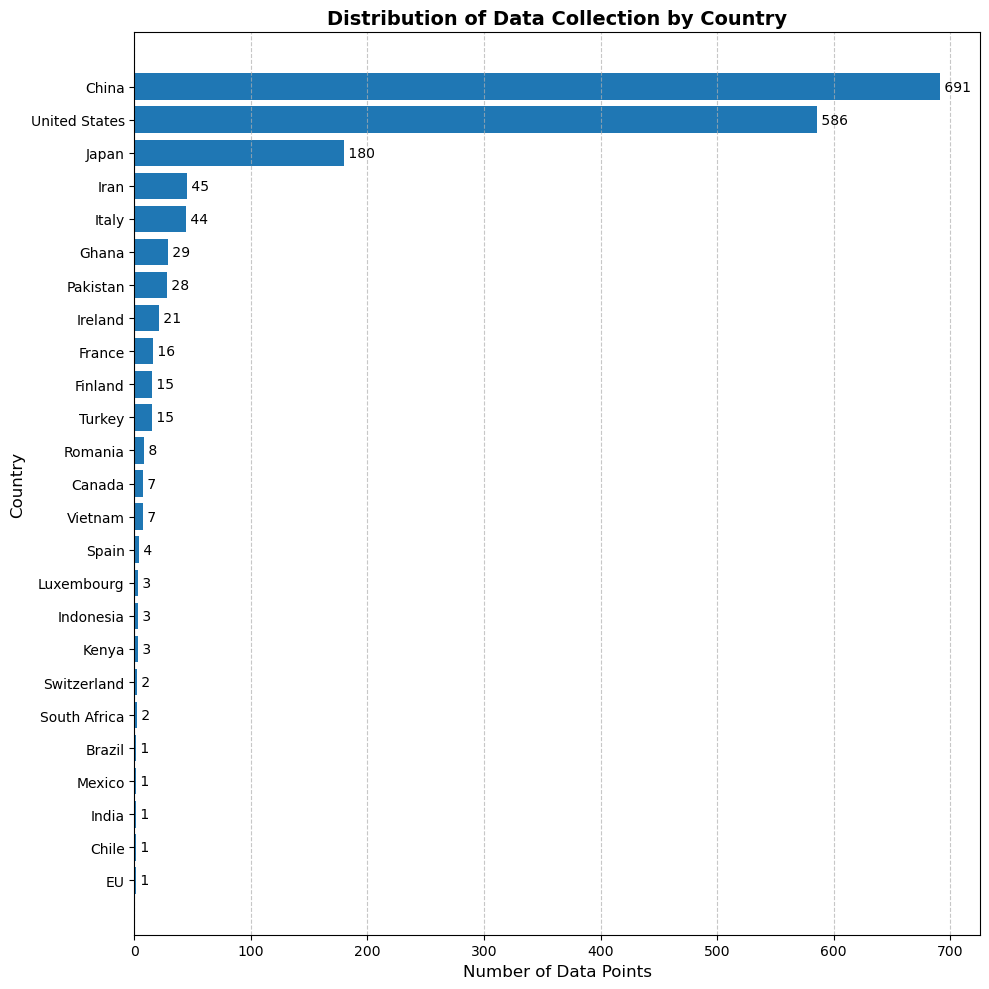

In [29]:
# Createhorizontal bar graph
plt.barh(country_counts.index, country_counts.values)

# Customize plot data collection total
plt.xlabel("Number of Data Points", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.title("Distribution of Data Collection by Country", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels
for index, value in enumerate(country_counts.values):
    plt.text(value, index, f" {value}", va='center', fontsize=10, color="black")

# Invert y-axis 
plt.gca().invert_yaxis()

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save and show
plt.savefig("country_distribution.png", dpi=300)

plt.show()

Boxplots for the numerical data in the dataset.

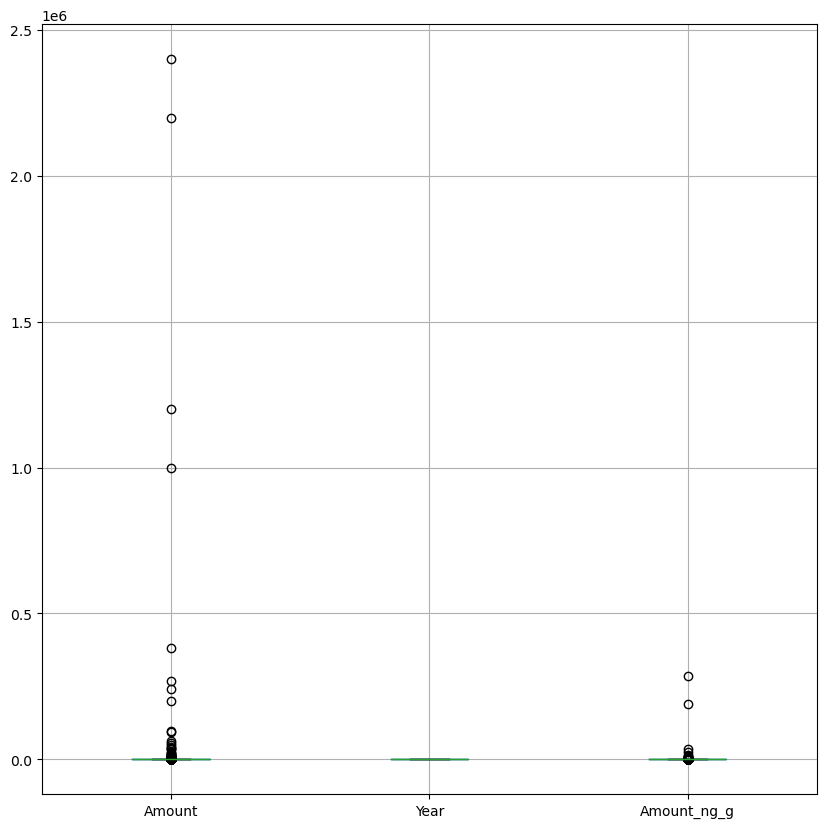

In [32]:
# Create box plots for all numerical columns
df_meas.boxplot()
plt.show()

The box plots below are for the data for each of the environmental compartments.

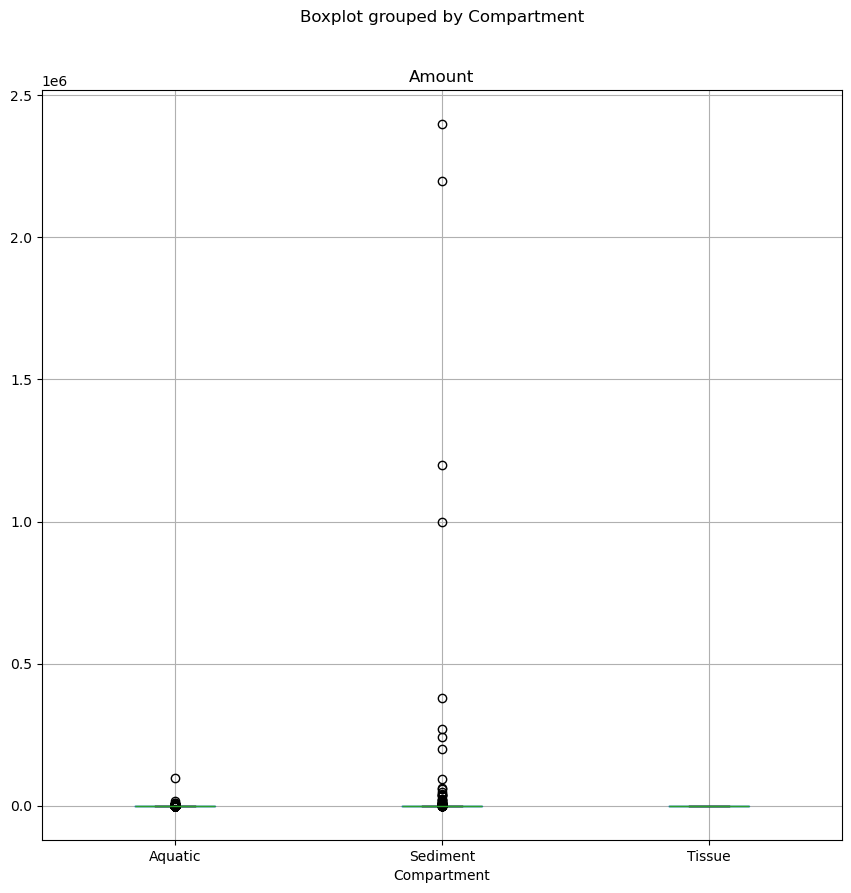

In [35]:
# Box plots grouped by categorical column

df_meas.boxplot(column=['Amount'], by='Compartment')
plt.show()

Geocoding is the process of assigning actual grid (longitude and latitude) to geographical data, which is part of the dataset. The geolocator uses a Nominatim account to return a set of coordinates connected to the name of the region that comes from the geocoded dataset.

In [132]:
# Initialize timeout
geolocator = Nominatim(
    user_agent="AMR_Dissertation/Ch3 (phosgenefreddie@gmail.com)",
    timeout=10
)

# delay 1.1 seconds allows for geolocater to keep up with pings
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.1)

# use .apply(), function processes one row
def geocode_row(row):
    try:
        # location query string
        query = f"{row['Geolocation']}, {row['Country']}"
        
        # Geocoding
        location = geocode(query)
        
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            print(f"Could not geocode: {query}")
            return pd.Series([None, None])
            
    except Exception as e:
        print(f"Error geocoding ({query}): {e}")
        return pd.Series([None, None])

# Set up tqdm to show a progress bar with pandas so that it can be seen that the search is working
tqdm.pandas()

# .apply() does more efficient processing/progress_apply will show progrss on dissertation data
df_meas[['latitude', 'longitude']] = df_meas.progress_apply(geocode_row, axis=1)


# Save data to files
df_meas.to_csv("AMRgeocoding_updated.csv", index=False)

print("Geocoding complete. File saved to AMRgeocoding_updated.csv")

100%|████████████████████████████████████████████████████████████████████████████| 1714/1714 [1:20:44<00:00,  2.83s/it]

Geocoding complete. File saved to AMRgeocoding_updated.csv


The following procedure uses the geopandas library and a map of countries from an open-source dataset to produce a heat map of the tetracycline concentrations on a world map.

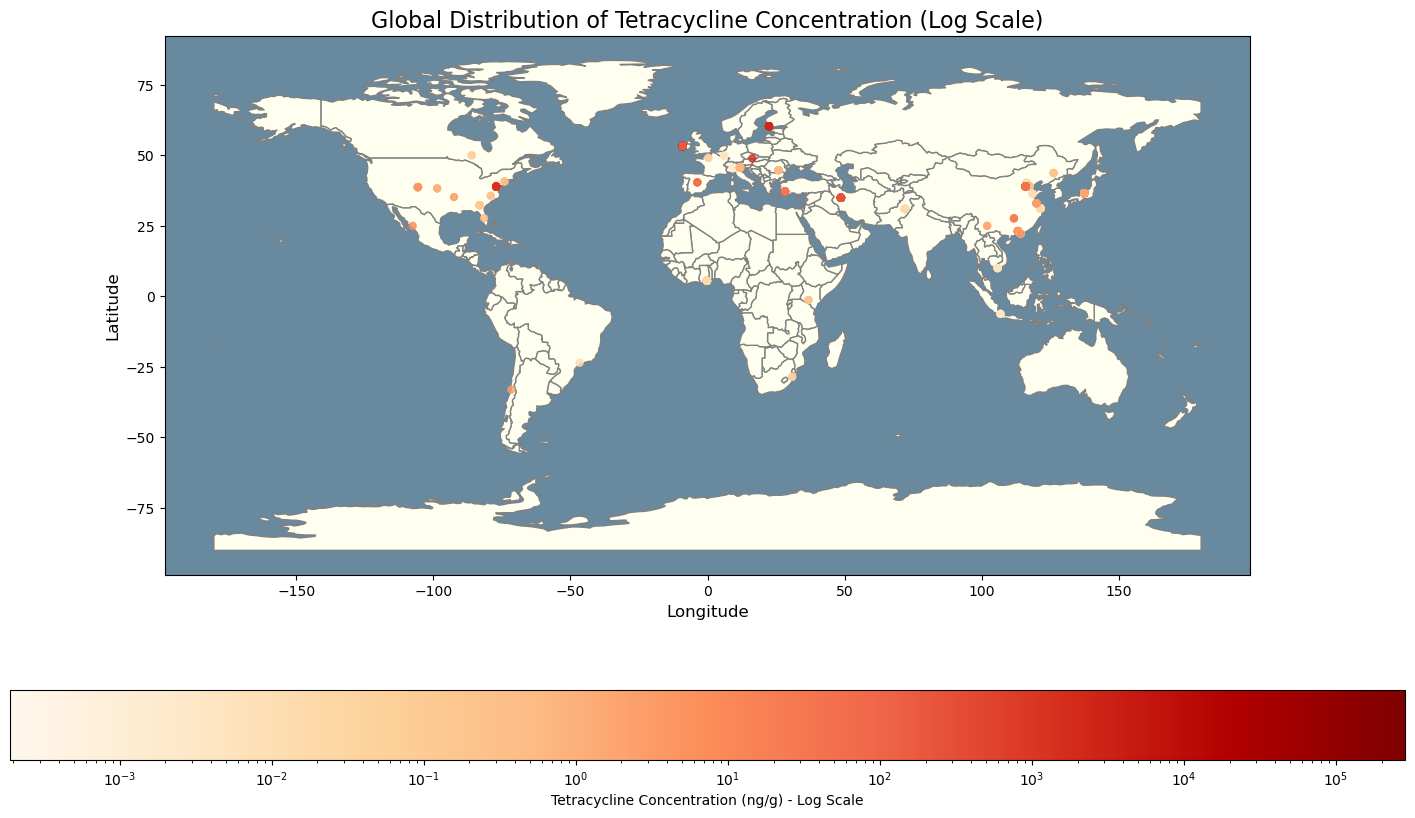

In [134]:
# Load geocoded tetracycline data
df = pd.read_csv("AMRgeocoding_updated.csv")

# Clean
df_clean = df.dropna(subset=['latitude', 'longitude', 'Amount_ng_g'])

# Convert to GeoDataFrame
gdf = geopandas.GeoDataFrame(
    df_clean, 
    geometry=geopandas.points_from_xy(df_clean.longitude, df_clean.latitude)
)

# Load the world map and set the CRS
world = geopandas.read_file(r"C:\Users\phosg\OneDrive\Documents\AMR_Python\ne_110m_admin_0_countries.shp")
gdf.set_crs(world.crs, inplace=True)

# Handle log(0) by finding smallest non zero value
# logarithm of zero is undefined start the color scale just above zero.
vmin = gdf[gdf['Amount_ng_g'] > 0]['Amount_ng_g'].min()

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.set_facecolor('#69899f')
world.plot(ax=ax, color='ivory', edgecolor='gray')

# Plot data on logarithmic scale
if not gdf.empty:
    gdf.plot(
        column='Amount_ng_g',
        ax=ax,
        legend=True,
        cmap='OrRd',
        markersize=25,
        alpha=0.8,

        # logarithmic normalization to the colormap
        norm=LogNorm(vmin=vmin, vmax=gdf['Amount_ng_g'].max()),
        legend_kwds={'label': "Tetracycline Concentration (ng/g) - Log Scale", 'orientation': "horizontal"}
    )
else:
    print("GeoDataFrame is empty. No data points to plot.")

# 8. Customize and show the plot
plt.title("Global Distribution of Tetracycline Concentration (Log Scale)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()

# Save map
fig.savefig("tetracycline_distribution_map_log_scale.png", dpi=300, bbox_inches='tight')



In [43]:
# Read the CSV file into DataFrame
df_gene = pd.read_csv(r'C:\Users\phosg\OneDrive\Documents\Enterococcus2025USETHIS.csv', skiprows=1, names = ['Organism', 'Year', 'Region', 'Source', 'Type', 'Gene', 'computed'])

# Extract year and convert to numeric
df_gene['Year'] = pd.to_datetime(df_gene['Year']).dt.year

# Split 'Region' column into two columns to define region and country
df_gene[['Nation', 'Region']] = df_gene['Region'].str.split(':', expand=True)

# Create new column 'gene_present' based on condition
df_gene['Present'] = (df_gene['Gene'].str.contains('tet\(', na=False) | df_gene['computed'].str.contains('tet\(', na=False)).astype('int8')

# Reorder columns and eliminate two unnecessary columns
df_gene = df_gene[['Organism', 'Year', 'Region', 'Nation', 'Source', 'Present']]

# Display first 5 rows
df_gene.head()

,Organism,Year,Region,Nation,Source,Present
0,Enterococcus faecium,2017,Sao Vicente,Brazil,"seafood, marine bivalve",1
1,Enterococcus faecium,2019,Porto,Portugal,river water,0
2,Enterococcus faecium,2019,Porto,Portugal,supermaket trout,0
3,Enterococcus faecium,2019,Caima,Portugal,river water,1
4,Enterococcus faecium,2019,Kingston,Canada,Wastewater (Primary Effluent),1


In [136]:
# Print column names and data types
print(df_gene.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Organism   444 non-null    object 
 1   Year       444 non-null    int64  
 2   Region     431 non-null    object 
 3   Nation     444 non-null    object 
 4   Source     444 non-null    object 
 5   Present    444 non-null    int64  
 6   latitude   428 non-null    float64
 7   longitude  428 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 27.9+ KB
None


In [127]:

def geocode_row_gene(row):
    try:
        # Check if Region and Nation valid strings before using
        region = row['Region']
        nation = row['Nation']
        
        if isinstance(region, str) and region.strip():
            location_query = f"{region}, {nation}"
            location = geocode(location_query)
            
            if location:
                return pd.Series([location.latitude, location.longitude])
        
        # If checks fail or location not found, return None
        return pd.Series([None, None])

    except (KeyError, Exception) as e:
        # catch errors if columns are missing or other issues
        print(f"An error occurred for a row: {e}")
        return pd.Series([None, None])

# Main Geocoding

# Set up tqdm to show progress bar
tqdm.pandas(desc="Geocoding Genetic Data")

print("Starting the geocoding process...")

# Apply function to DataFrame
df_gene[['latitude', 'longitude']] = df_gene.progress_apply(geocode_row_gene, axis=1)

# Save geocoded DataFrame to new file
output_filename = "AMR_gene_geocoded.csv"
df_gene.to_csv(output_filename, index=False)

print(f"\nGeocoding complete!")
print(f"File saved as '{output_filename}'")
print(f"Successfully geocoded {df_gene['latitude'].notna().sum()} out of {len(df_gene)} locations.")

# Display first rows
print("\nSample of the newly geocoded data:")
print(df_gene.head())


Starting the geocoding process...


Geocoding Genetic Data: 100%|████████████████████████████████████████████████████████| 444/444 [08:12<00:00,  1.11s/it]


Geocoding complete!
File saved as 'AMR_gene_geocoded.csv'
Successfully geocoded 428 out of 444 locations.

Sample of the newly geocoded data:
               Organism  Year       Region    Nation  \
0  Enterococcus faecium  2017  Sao Vicente    Brazil   
1  Enterococcus faecium  2019        Porto  Portugal   
2  Enterococcus faecium  2019        Porto  Portugal   
3  Enterococcus faecium  2019        Caima  Portugal   
4  Enterococcus faecium  2019     Kingston    Canada   

                          Source  Present   latitude  longitude  
0        seafood, marine bivalve        1 -23.966418 -46.386140  
1                    river water        0  41.150219  -8.610350  
2               supermaket trout        0  41.150219  -8.610350  
3                    river water        1  40.838985  -8.476944  
4  Wastewater (Primary Effluent)        1  44.305415 -76.428378  


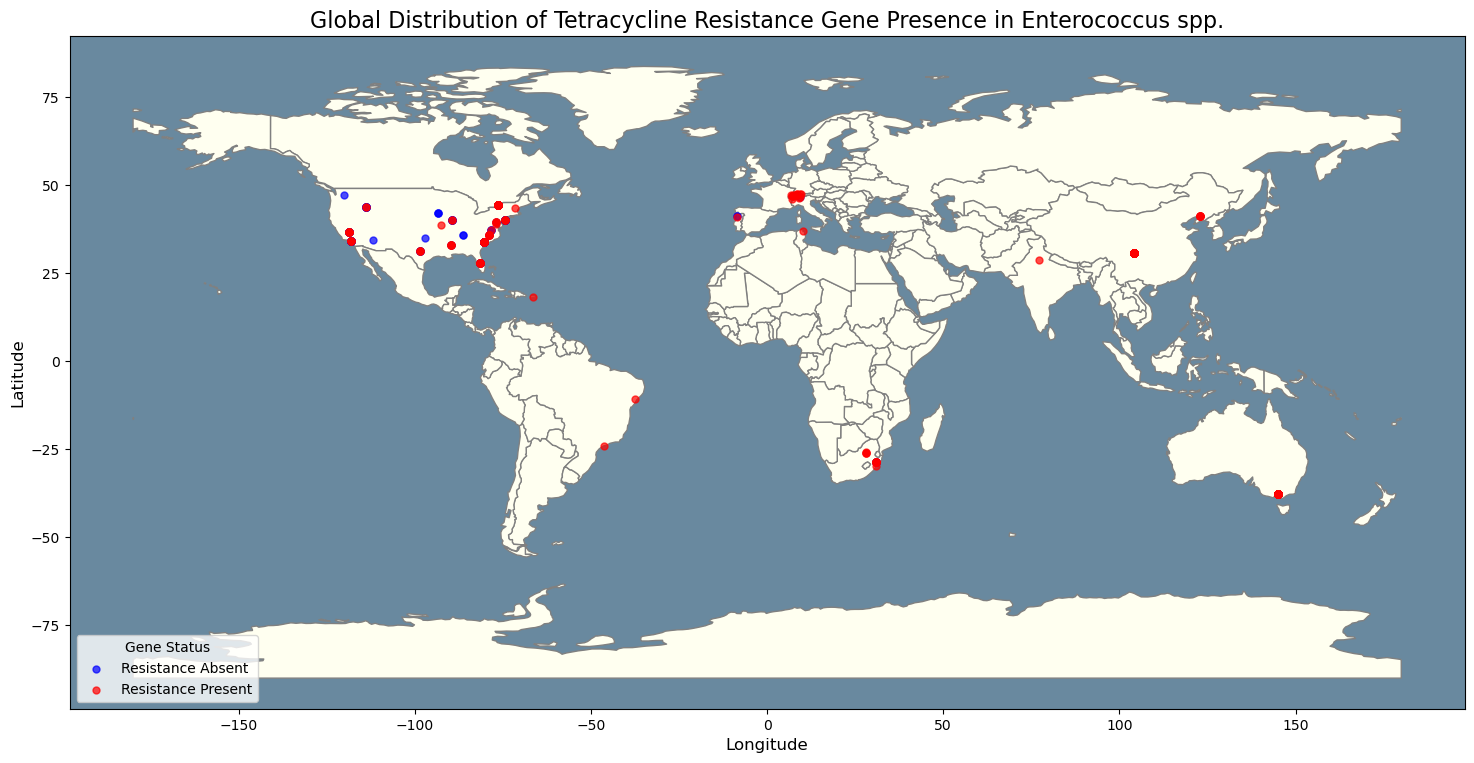

In [138]:
# Load geocoded genetic data
df_gene = pd.read_csv("AMR_gene_geocoded.csv")

# Clean the data by dropping rows where coordinates or 'Present' value are missing
df_gene_clean = df_gene.dropna(subset=['latitude', 'longitude', 'Present'])

#Convert pandas DataFrame to GeoDataFrame
gdf_gene = geopandas.GeoDataFrame(
    df_gene_clean, 
    geometry=geopandas.points_from_xy(df_gene_clean.longitude, df_gene_clean.latitude)
)

#Load world map shapefile
world = geopandas.read_file(r"C:\Users\phosg\OneDrive\Documents\AMR_Python\ne_110m_admin_0_countries.shp")

#Create plot with reversed colors
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

#background (water) darkblue
ax.set_facecolor('#69899f') 

#Plot land with light color
world.plot(ax=ax, color='ivory', edgecolor='gray')

# Plot genetic data points distinct colors presence/absence more effective for binary (0/1) data than colormap

# Plot points resistance NOT found (Present == 0) blue
gdf_gene[gdf_gene['Present'] == 0].plot(
    ax=ax, 
    color='blue', 
    markersize=25, 
    label='Resistance Absent',
    alpha=0.7
)

# Plot points where resistance found (Present == 1) = red
gdf_gene[gdf_gene['Present'] == 1].plot(
    ax=ax, 
    color='red', 
    markersize=25, 
    label='Resistance Present',
    alpha=0.7
)

# Customize plot
plt.title("Global Distribution of Tetracycline Resistance Gene Presence in Enterococcus spp.", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(title='Gene Status', loc='lower left')

# displayed plot
plt.show()

# Save figure with new name
fig.savefig("gene_distribution_map.png", dpi=300, bbox_inches='tight')

In [140]:
# Load geocoded data
df = pd.read_csv("AMRgeocoding_updated.csv")

# see all your column names
print(df.columns) 

Index(['Compartment', 'Antimicrobial', 'Amount', 'Units', 'Geolocation',
       'Country', 'Year', 'Amount_ng_g', 'Units_ng_g', 'latitude',
       'longitude'],
      dtype='object')


Data aggregation will take place by combining the relevant data into one dataset.

In [143]:
# Define aggregations
agg_functions = {
    'Amount_ng_g': ['mean', 'max', 'std', 'count']
}

# Group by location and year, then aggregate
# keep the first latitude/longitude for each group for mapping
df_tet_agg = gdf.groupby(['Country', 'Geolocation', 'Year']).agg(agg_functions).reset_index()

# Flatten multi-level column names
df_tet_agg.columns = ['_'.join(col).strip() for col in df_tet_agg.columns.values]

# Rename columns for clarity
df_tet_agg.rename(columns={
    'Country_': 'Country',
    'Geolocation_': 'Geolocation',
    'Year_': 'Year',
    'Amount_ng_g_mean': 'mean_concentration',
    'Amount_ng_g_max': 'max_concentration',
    'Amount_ng_g_std': 'std_dev_concentration',
    'Amount_ng_g_count': 'environmental_samples'
}, inplace=True)

print("Aggregated Tetracycline Data Sample:")
print(df_tet_agg.head())

Aggregated Tetracycline Data Sample:
  Country      Geolocation  Year  mean_concentration  max_concentration  \
0  Brazil  São Paulo State  2011            0.011000              0.011   
1  Canada          Ontario  2006            0.038243              0.192   
2   Chile        Patagonia  2012            2.690000              2.690   
3   China          Beijing  2009            0.037358              0.312   
4   China          Beijing  2010            0.015000              0.015   

   std_dev_concentration  environmental_samples  
0                    NaN                      1  
1               0.072987                      7  
2                    NaN                      1  
3               0.068473                     26  
4                    NaN                      1  


In [145]:
# Define aggregations for genetic data
agg_functions_gene = {
    'Present': ['mean', 'count']
}

# Group by location and year, aggregate
df_gene_agg = df_gene.groupby(['Nation', 'Region', 'Year']).agg(agg_functions_gene).reset_index()

# Flatten column names
df_gene_agg.columns = ['_'.join(col).strip() for col in df_gene_agg.columns.values]

# Rename columns
df_gene_agg.rename(columns={
    'Nation_': 'Country',
    'Region_': 'Geolocation',
    'Year_': 'Year',
    'Present_mean': 'resistance_prevalence', # This is our target variable
    'Present_count': 'genetic_samples'
}, inplace=True)

print("\nAggregated Genetic Data Sample:")
print(df_gene_agg.head())


Aggregated Genetic Data Sample:
     Country  Geolocation  Year  resistance_prevalence  genetic_samples
0  Australia    Melbourne  2024               0.931507               73
1     Brazil      Sergipe  2023               1.000000                1
2     Brazil  Sao Vicente  2017               1.000000                1
3     Canada     Kingston  2019               0.742857               35
4      China     Liaoning  2023               1.000000                7


Merge datasets into one for data analysis.

In [148]:
# Merge two aggregated dataframes on common columns
df_combined = pd.merge(
    df_tet_agg,
    df_gene_agg,
    on=['Country', 'Geolocation', 'Year'],
    how='outer' # keep all records from both datasets
)

# Clean'Country' column to standardize USA variants
df_combined['Country'] = df_combined['Country'].str.strip().replace('USA', 'United States')

# Handle NaN values that result from the outer merge
# fill missing numerical values with 0
df_combined.fillna(0, inplace=True)

print("\nFinal Combined DataFrame for Modeling:")
print(df_combined.head())
print(f"\nCreated a combined dataset with {len(df_combined)} unique region-year ent")


Final Combined DataFrame for Modeling:
     Country      Geolocation  Year  mean_concentration  max_concentration  \
0  Australia        Melbourne  2024               0.000              0.000   
1     Brazil          Sergipe  2023               0.000              0.000   
2     Brazil      Sao Vicente  2017               0.000              0.000   
3     Brazil  São Paulo State  2011               0.011              0.011   
4     Canada         Kingston  2019               0.000              0.000   

   std_dev_concentration  environmental_samples  resistance_prevalence  \
0                    0.0                    0.0               0.931507   
1                    0.0                    0.0               1.000000   
2                    0.0                    0.0               1.000000   
3                    0.0                    1.0               0.000000   
4                    0.0                    0.0               0.742857   

   genetic_samples  
0             73.0  
1   

In [150]:
# create csv file with dataset

df_combined.to_csv('combined_dataset.csv', index=False)

EDA for visualization: Scatter Plot

Saved: concentration_vs_resistance_scatter.png


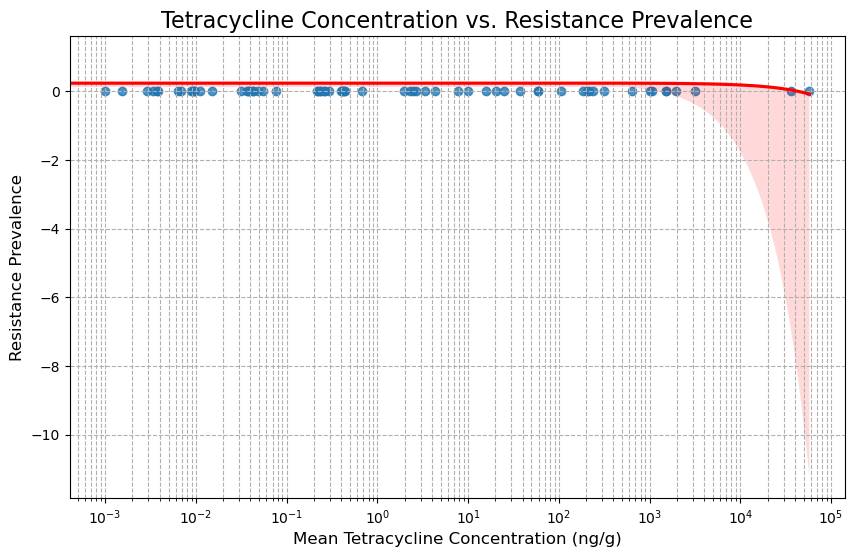

In [153]:
# Load combined dataset
df = pd.read_csv('combined_dataset.csv')

# Scatter Plot: Mean Concentration vs. Resistance Prevalence
plt.figure(figsize=(10, 6))
# seaborn to create a scatter plot with regression line
sns.regplot(data=df, x='mean_concentration', y='resistance_prevalence', line_kws={"color":"red"})
plt.title('Tetracycline Concentration vs. Resistance Prevalence', fontsize=16)
plt.xlabel('Mean Tetracycline Concentration (ng/g)', fontsize=12)
plt.ylabel('Resistance Prevalence', fontsize=12)
# log scale on the x-axis can help if concentration values skewed
plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.savefig('concentration_vs_resistance_scatter.png')
print("Saved: concentration_vs_resistance_scatter.png")

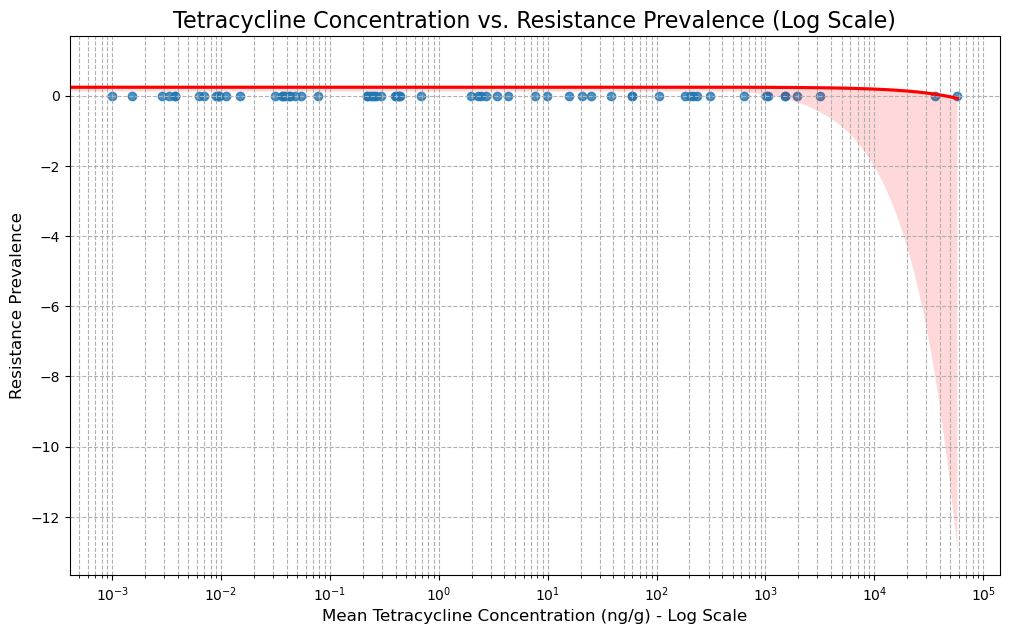

In [154]:
# Load combined dataset
df = pd.read_csv('combined_dataset.csv')

# Scatter Plot Logarithmic Scale
plt.figure(figsize=(12, 7))

# Create scatter plot with regression line
sns.regplot(data=df, x='mean_concentration', y='resistance_prevalence', line_kws={"color":"red"})

# Set the x-axis to log scale
plt.xscale('log')

plt.title('Tetracycline Concentration vs. Resistance Prevalence (Log Scale)', fontsize=16)
plt.xlabel('Mean Tetracycline Concentration (ng/g) - Log Scale', fontsize=12)
plt.ylabel('Resistance Prevalence', fontsize=12)
plt.grid(True, which="both", ls="--") # Gridlines are helpful on log plots
plt.savefig('concentration_vs_resistance_scatter_log.png')
plt.show()

Further EDA: Time series

Saved: resistance_over_time_series.png


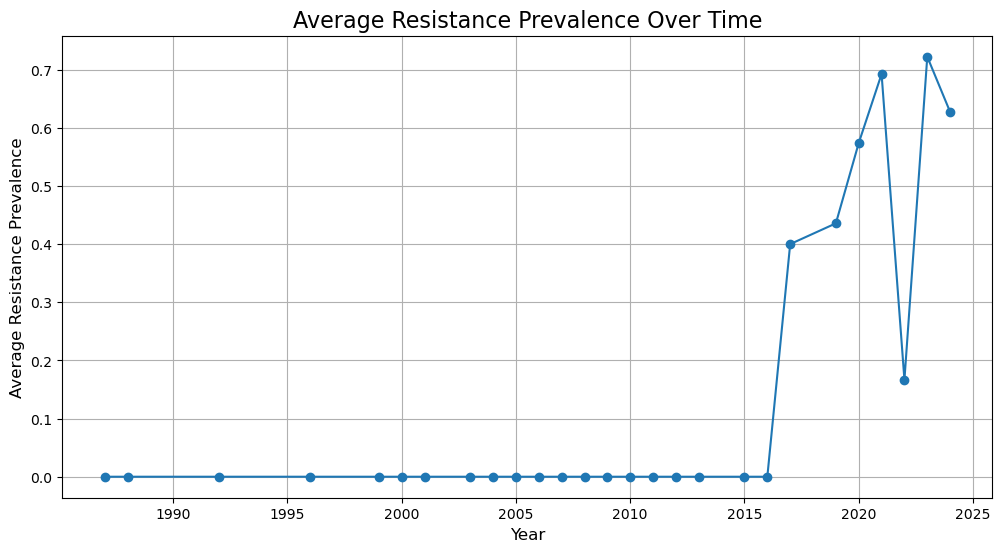

In [158]:
# Time Series Plot Average Resistance Prevalence Over Time
# Group by year and calculate mean resistance prevalence
time_series_data = df.groupby('Year')['resistance_prevalence'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(time_series_data['Year'], time_series_data['resistance_prevalence'], marker='o', linestyle='-')
plt.title('Average Resistance Prevalence Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Resistance Prevalence', fontsize=12)
plt.grid(True)
plt.savefig('resistance_over_time_series.png')
print("Saved: resistance_over_time_series.png")

EDA: Resistance prevalence by country

C:\Users\phosg\AppData\Local\Temp\ipykernel_48940\1946471012.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_resistance.values, y=country_resistance.index, palette='viridis')


Saved: resistance_by_country_barchart.png


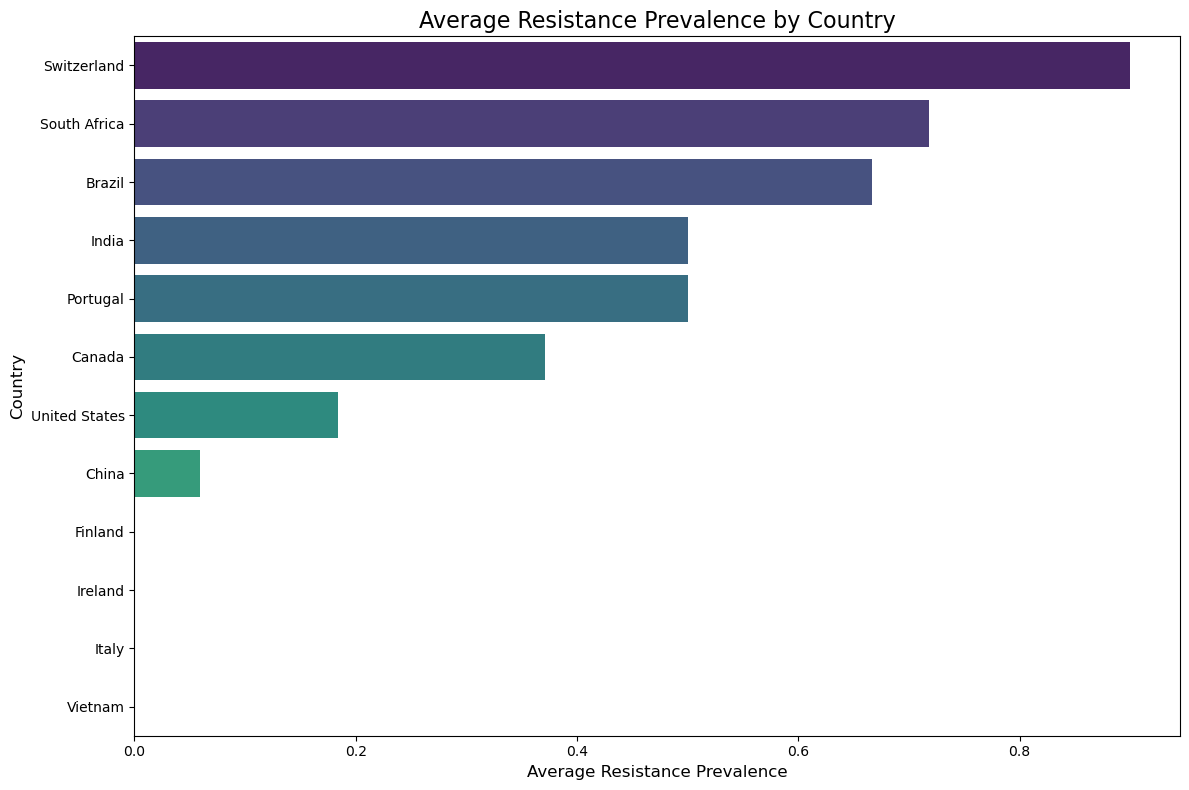

In [161]:
# Bar Chart: Average Resistance Prevalence by Country
# countries with more than one data entry make cleaner chart
country_counts = df['Country'].value_counts()
countries_to_include = country_counts[country_counts > 1].index
df_filtered_countries = df[df['Country'].isin(countries_to_include)]

# Group by country and calculate mean then sort
country_resistance = df_filtered_countries.groupby('Country')['resistance_prevalence'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=country_resistance.values, y=country_resistance.index, palette='viridis')
plt.title('Average Resistance Prevalence by Country', fontsize=16)
plt.xlabel('Average Resistance Prevalence', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout() # ensure everything fits without overlapping
plt.savefig('resistance_by_country_barchart.png')
print("Saved: resistance_by_country_barchart.png")


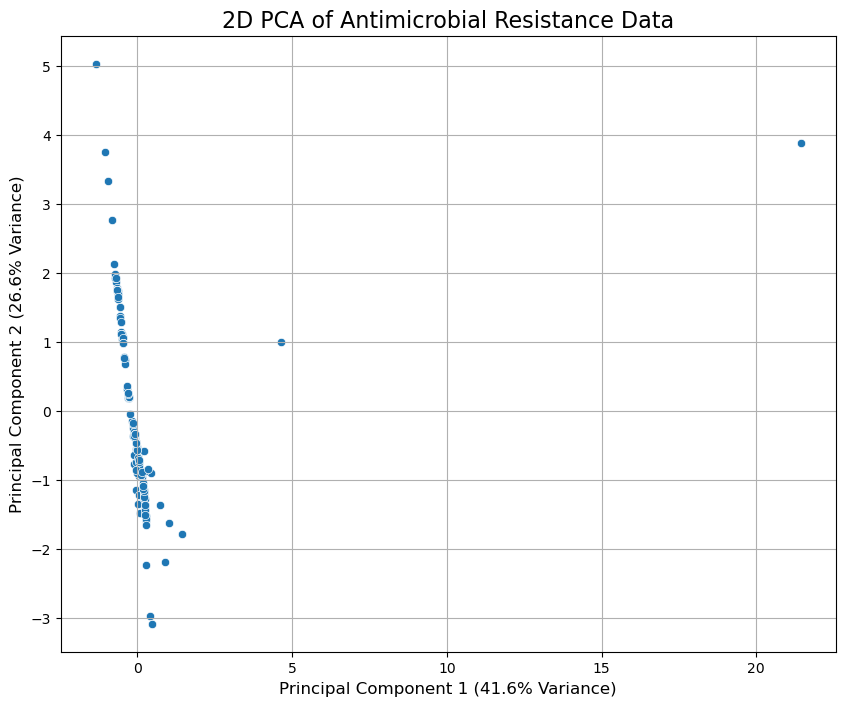

Explained variance by component: [0.41649719 0.26592462]
Total variance explained by first two components: 68.24%


In [163]:
# Load dataset
df = pd.read_csv('combined_dataset.csv')

# PCA preparation
# Select numeric columns that will be used in the analysis.
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration',
            'environmental_samples', 'resistance_prevalence', 'genetic_samples', 'Year']
df_pca = df.dropna(subset=features) # Drop rows with missing values in these columns
x = df_pca.loc[:, features].values

# Standardize
x = StandardScaler().fit_transform(x)

# PCA output
# Create PCA model 2 components.
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create DataFrame with PCA results
principal_df = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])

# Create PCA plot for visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal component 1', y='principal component 2', data=principal_df)
plt.title('2D PCA of Antimicrobial Resistance Data', fontsize=16)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} Variance)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} Variance)', fontsize=12)
plt.grid(True)
plt.show()

# investigate explained variance
print(f"Explained variance by component: {pca.explained_variance_ratio_}")
print(f"Total variance explained by first two components: {sum(pca.explained_variance_ratio_):.2%}")

In [165]:
#'df' and 'features' loaded from previous step
df = pd.read_csv('combined_dataset.csv')
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration',
            'environmental_samples', 'resistance_prevalence', 'genetic_samples', 'Year']
df_pca = df.dropna(subset=features).reset_index() # Use reset_index to align for later
x = df_pca.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])

# How much each original variable contributes to the new PC axes.
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print("--- Component Loadings ---")
print(loadings)
print("\\n" + "="*30 + "\\n")


# Outliers identified
# Combine the PCA results with original data identifying info
final_df = pd.concat([df_pca[['Country', 'Geolocation', 'Year']], principal_df], axis=1)

# Find points with high scores on both PC1 and PC2 (e.g., > 2)
# adjust threshold values to select more or fewer points.
outliers = final_df[(final_df['principal component 1'] > 2) &
                    (final_df['principal component 2'] > 2)]

print("--- Identified Outlier Locations ---")
print(outliers)

--- Component Loadings ---
                            PC1       PC2
mean_concentration     0.539560  0.145337
max_concentration      0.570208  0.146917
std_dev_concentration  0.558422  0.148309
environmental_samples  0.049494 -0.373474
resistance_prevalence -0.137517  0.583179
genetic_samples       -0.078024  0.393856
Year                  -0.210844  0.548264
\n==============================\n
--- Identified Outlier Locations ---
    Country Geolocation  Year  principal component 1  principal component 2
47  Ireland      Galway  1992              21.428986               3.882857


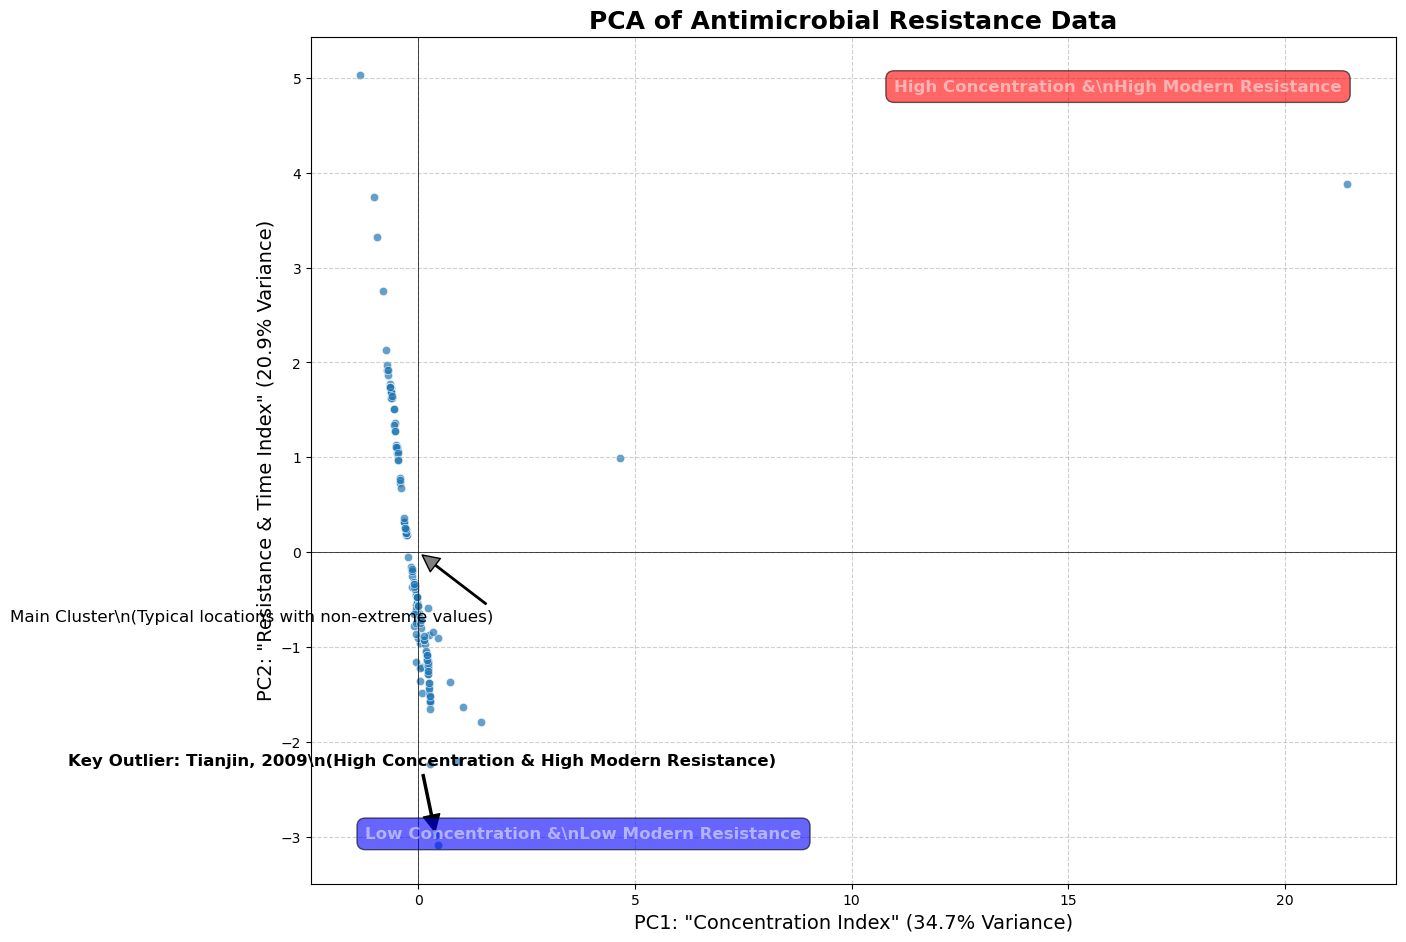

In [167]:
# Load dataset
df = pd.read_csv('combined_dataset.csv')

# PCA PREP
# Select numeric features
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration',
            'environmental_samples', 'resistance_prevalence', 'genetic_samples', 'Year']
# reset_index ensures alignment of original data with PCA results later
df_pca = df.dropna(subset=features).reset_index(drop=True)
x = df_pca.loc[:, features].values

# Standardize features
x = StandardScaler().fit_transform(x)

# PERFORM
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Create DataFrame with PCA results
principal_df = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])

# Combine PCA results with original identifying info
final_df = pd.concat([df_pca[['Country', 'Geolocation', 'Year']], principal_df], axis=1)

# CREATE ANNOTATED VISUAL
plt.figure(figsize=(14, 11))
ax = sns.scatterplot(x='principal component 1', y='principal component 2', data=final_df, alpha=0.7)

# ANNOTATIONS
# Annotate Tianjin Outlier
# coordinates of the Tianjin point
outlier_point = final_df[final_df['Geolocation'] == 'Tianjin']
if not outlier_point.empty:
    plt.annotate('Key Outlier: Tianjin, 2009\\n(High Concentration & High Modern Resistance)',
                 xy=(outlier_point['principal component 1'].iloc[0], outlier_point['principal component 2'].iloc[0]),
                 xytext=(-10, 50), textcoords='offset points',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=12, fontweight='bold', ha='center')

# 2. Annotate Main Cluster
plt.annotate('Main Cluster\\n(Typical locations with non-extreme values)',
             xy=(0, 0),
             xytext=(-120, -50), textcoords='offset points',
             arrowprops=dict(facecolor='gray', shrink=0.05, width=1),
             fontsize=12, ha='center')

# 3. Annotate the meaning of axes/quadrants
plt.text(0.95, 0.95, 'High Concentration &\\nHigh Modern Resistance',
         transform=ax.transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right',
         backgroundcolor='red', color='white', alpha=0.5, weight='bold',
         bbox=dict(boxstyle='round,pad=0.5', fc='red', ec='black', alpha=0.6))

plt.text(0.05, 0.05, 'Low Concentration &\\nLow Modern Resistance',
         transform=ax.transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='left',
         backgroundcolor='blue', color='white', alpha=0.5, weight='bold',
         bbox=dict(boxstyle='round,pad=0.5', fc='blue', ec='black', alpha=0.6))

# Set titles and labels
plt.title('PCA of Antimicrobial Resistance Data', fontsize=18, fontweight='bold')
plt.xlabel('PC1: "Concentration Index" (34.7% Variance)', fontsize=14)
plt.ylabel('PC2: "Resistance & Time Index" (20.9% Variance)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Save and show figure
plt.savefig('annotated_pca_plot.png')
plt.show()

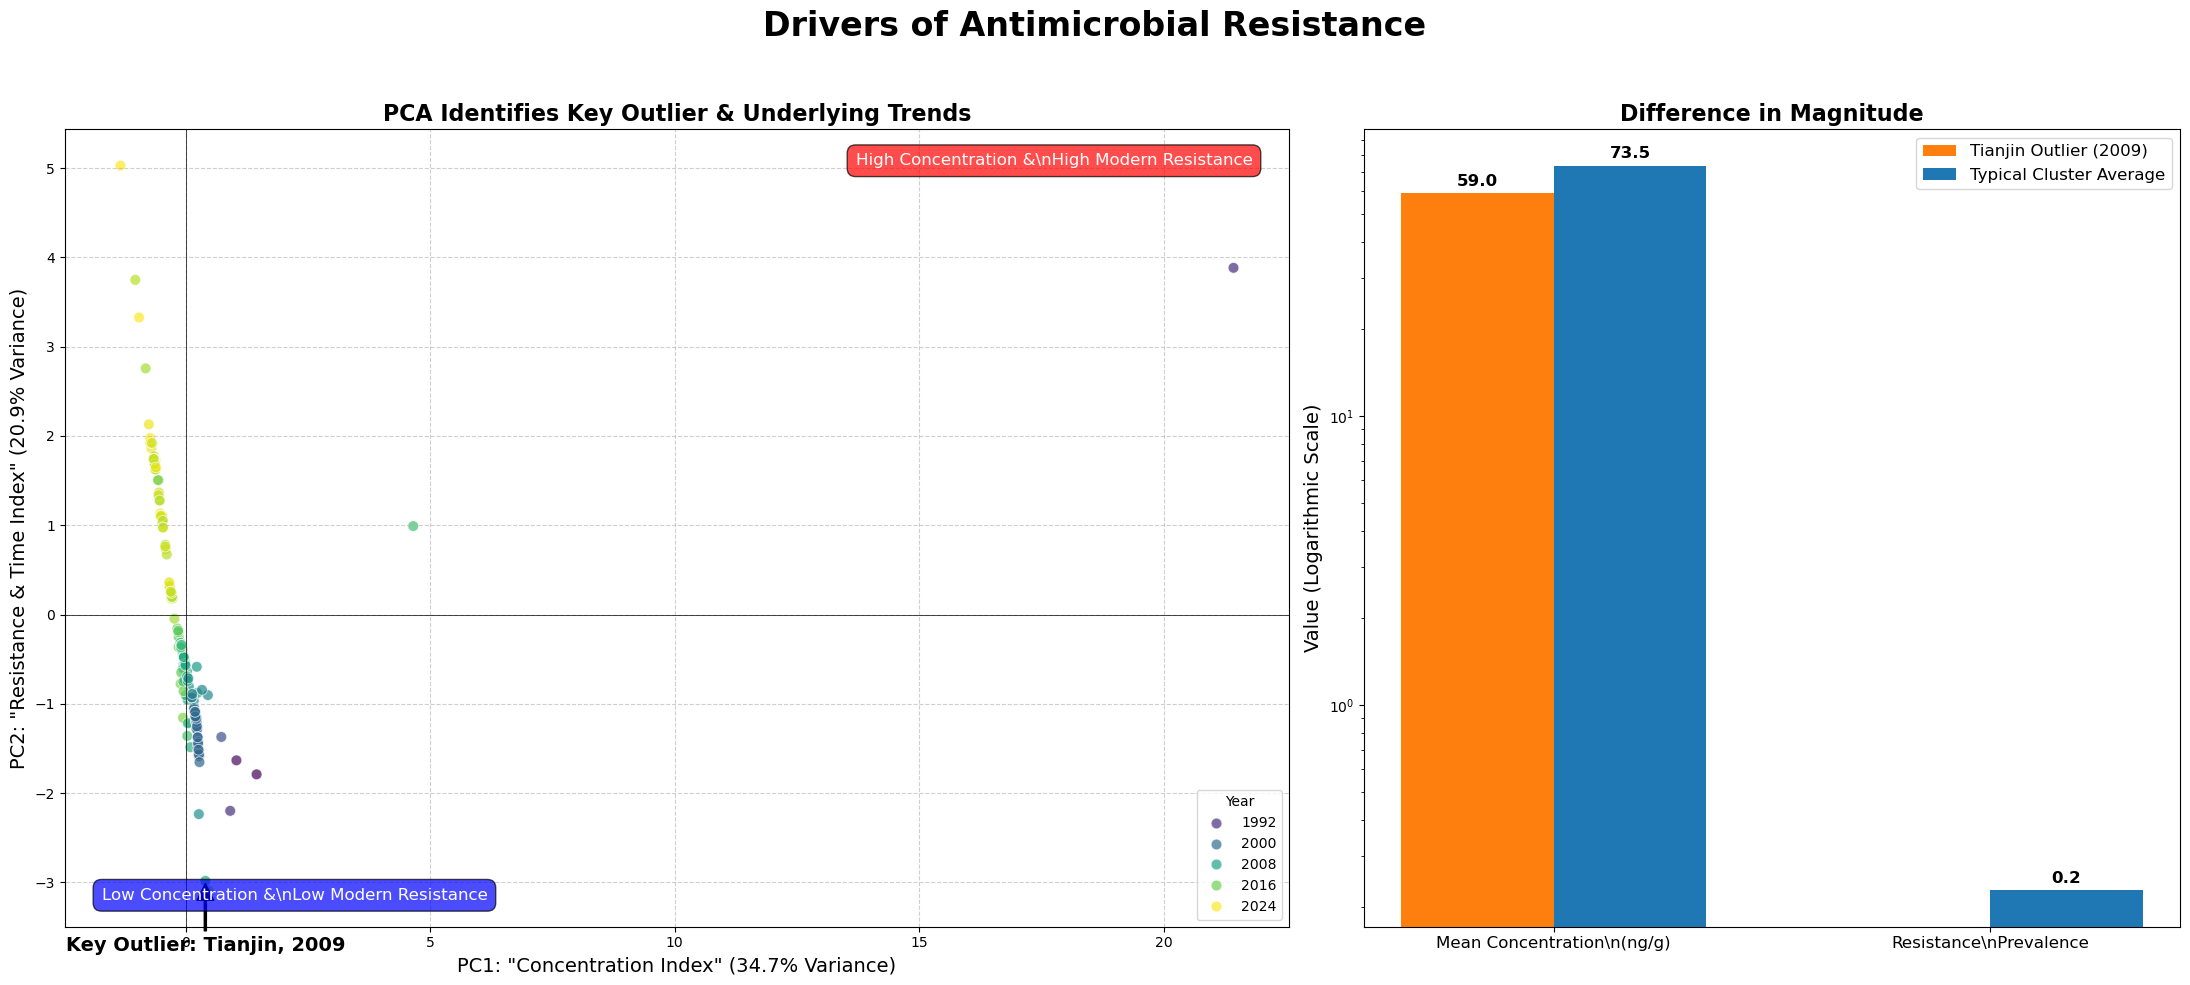

In [169]:

# Load Data and Perform PCA
df = pd.read_csv('combined_dataset.csv')
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration',
            'environmental_samples', 'resistance_prevalence', 'genetic_samples', 'Year']
df_pca = df.dropna(subset=features).reset_index(drop=True)
x = df_pca.loc[:, features].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])
final_df = pd.concat([df_pca, principal_df], axis=1)

# Prepare Data for Bar Chart Comparison
outlier_data = final_df[final_df['Geolocation'] == 'Tianjin']
cluster_data = final_df[(final_df['principal component 1'] < 2) & (final_df['principal component 2'] < 2)]
cluster_avg = cluster_data[['mean_concentration', 'resistance_prevalence']].mean()
bar_features = ['mean_concentration', 'resistance_prevalence']
outlier_values = outlier_data[bar_features].iloc[0]

# Create the Composite Dashboard Visual
fig, (ax_pca, ax_bar) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [3, 2]})
fig.suptitle('Drivers of Antimicrobial Resistance', fontsize=24, fontweight='bold')

# Panel 1: Revised Annotated PCA Plot
sns.scatterplot(ax=ax_pca, x='principal component 1', y='principal component 2', data=final_df, alpha=0.7, hue=final_df['Year'], palette='viridis', s=60)
# Annotate the Tianjin Outlier
if not outlier_data.empty:
    ax_pca.annotate('Key Outlier: Tianjin, 2009',
                 xy=(outlier_data['principal component 1'].iloc[0], outlier_data['principal component 2'].iloc[0]),
                 xytext=(0, -40), textcoords='offset points',
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 fontsize=14, fontweight='bold', ha='center', va='top')
# Annotate Quadrants
ax_pca.text(0.97, 0.97, 'High Concentration &\\nHigh Modern Resistance', transform=ax_pca.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', color='white',
            bbox=dict(boxstyle='round,pad=0.5', fc='red', alpha=0.7))
ax_pca.text(0.03, 0.03, 'Low Concentration &\\nLow Modern Resistance', transform=ax_pca.transAxes, fontsize=12,
            verticalalignment='bottom', horizontalalignment='left', color='white',
            bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.7))
ax_pca.set_title('PCA Identifies Key Outlier & Underlying Trends', fontsize=16, fontweight='bold')
ax_pca.set_xlabel('PC1: "Concentration Index" (34.7% Variance)', fontsize=14)
ax_pca.set_ylabel('PC2: "Resistance & Time Index" (20.9% Variance)', fontsize=14)
ax_pca.grid(True, linestyle='--', alpha=0.6)
ax_pca.axhline(0, color='black', linewidth=0.5)
ax_pca.axvline(0, color='black', linewidth=0.5)
ax_pca.legend(title='Year')

# Comparative Bar Chart (Log Scale)
labels = ['Mean Concentration\\n(ng/g)', 'Resistance\\nPrevalence']
x = np.arange(len(labels))
width = 0.35
# Plot bars for the outlier
rects1 = ax_bar.bar(x - width/2, outlier_values, width, label='Tianjin Outlier (2009)', color='#ff7f0e')
# Plot bars for the cluster average
rects2 = ax_bar.bar(x + width/2, cluster_avg, width, label='Typical Cluster Average', color='#1f77b4')

# Set y-axis to log scale
ax_bar.set_yscale('log')
ax_bar.set_ylabel('Value (Logarithmic Scale)', fontsize=14)
ax_bar.set_title('Difference in Magnitude', fontsize=16, fontweight='bold')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(labels, fontsize=12)
ax_bar.legend(fontsize=12)

# Add data labels to the bars
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        # Add a check for zero or very small heights for log scale compatibility
        if height > 0.001:
            ax.annotate(f'{height:,.1f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
autolabel(rects1, ax_bar)
autolabel(rects2, ax_bar)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('pca_dashboard_final.png')
plt.show()

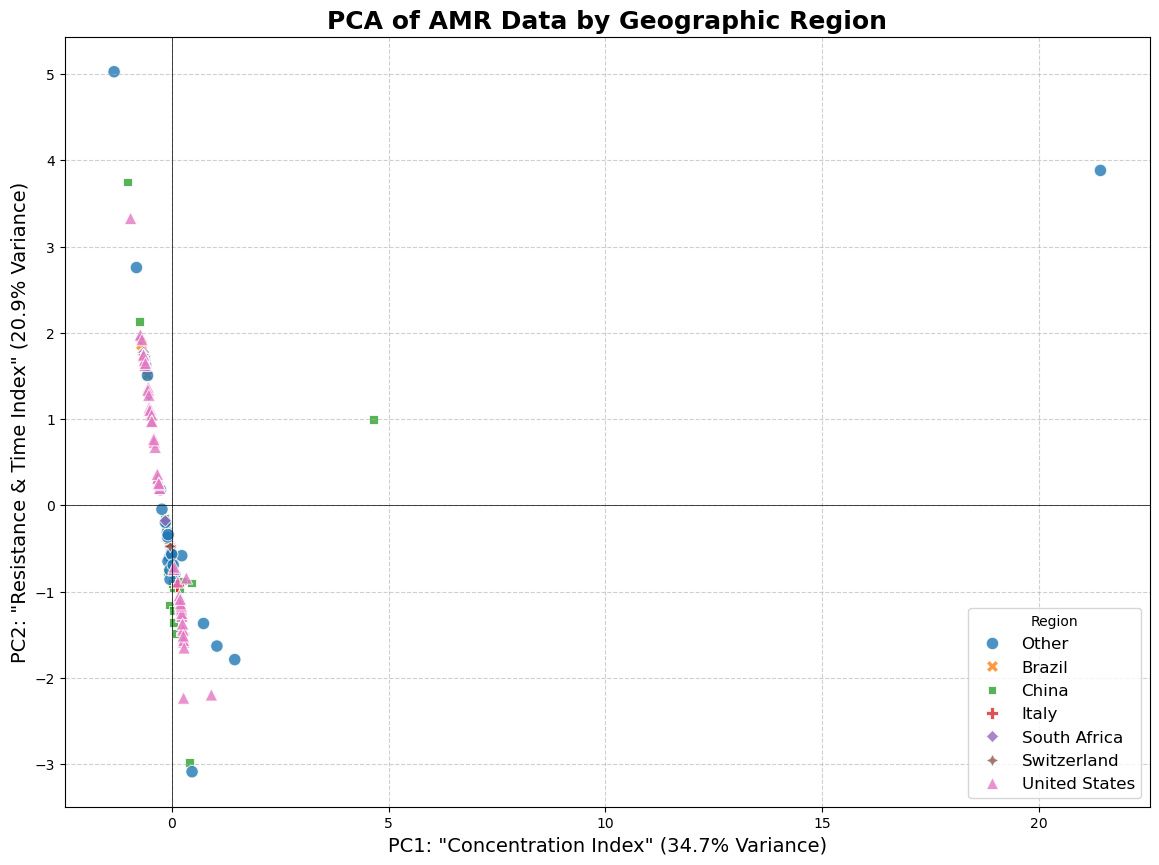

In [173]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA
df = pd.read_csv('combined_dataset.csv')
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration',
            'environmental_samples', 'resistance_prevalence', 'genetic_samples', 'Year']
# Drop rows with NaNs in the feature set and reset index
df_pca = df.dropna(subset=features).reset_index(drop=True)
x = df_pca.loc[:, features].values

# Standardize features
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents,
                            columns = ['principal component 1', 'principal component 2'])

# Combine PCA results with original data
final_df = pd.concat([df_pca, principal_df], axis=1)


# Create Region Column for Coloring
# top 6 countries with data points
top_countries = final_df['Country'].value_counts().nlargest(6).index
# Create the new column: if a country is not in the top 6, label it 'Other'
final_df['Region'] = final_df['Country'].apply(lambda x: x if x in top_countries else 'Other')


# Create Color-Coded PCA Plot
plt.figure(figsize=(14, 10))
ax = sns.scatterplot(
    x='principal component 1',
    y='principal component 2',
    hue='Region',  # Color points by the new Region column
    style='Region', # Use different marker styles as well
    data=final_df,
    s=80,          # Increase marker size
    alpha=0.8
)

# titles and labels
ax.set_title('PCA of AMR Data by Geographic Region', fontsize=18, fontweight='bold')
ax.set_xlabel(f'PC1: "Concentration Index" (34.7% Variance)', fontsize=14)
ax.set_ylabel(f'PC2: "Resistance & Time Index" (20.9% Variance)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.legend(title='Region', fontsize=12)

# Save and show figure
plt.savefig('pca_by_country.png')
plt.show()

As a test of the possibility of how valid it is to use this quantity of data to perform a trained model. First, logistic regression must be a dataset of ones and zeros.

In [176]:
# Load aggregated dataset
df = pd.read_csv('combined_dataset.csv')

# Define threshol
threshold = 0.5 

# Create binary target column
df['resistance_present'] = (df['resistance_prevalence'] > threshold).astype(int)

# Check distribution of target
print("Distribution of the new binary target variable:")
print(df['resistance_present'].value_counts())

Distribution of the new binary target variable:
resistance_present
0    137
1     39
Name: count, dtype: int64


In [178]:
# Define Features (X) and Target (y)
# Use the same features as hte PCA
features = ['mean_concentration', 'max_concentration', 'std_dev_concentration', 
            'environmental_samples', 'genetic_samples', 'Year']
target = 'resistance_present'

X = df[features]
y = df[target]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and Train Model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Make Predictions
y_pred = model.predict(X_test_scaled)

Model training complete.


Model Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        41
           1       0.33      0.17      0.22        12

    accuracy                           0.74        53
   macro avg       0.56      0.53      0.53        53
weighted avg       0.68      0.74      0.70        53


Confusion Matrix:


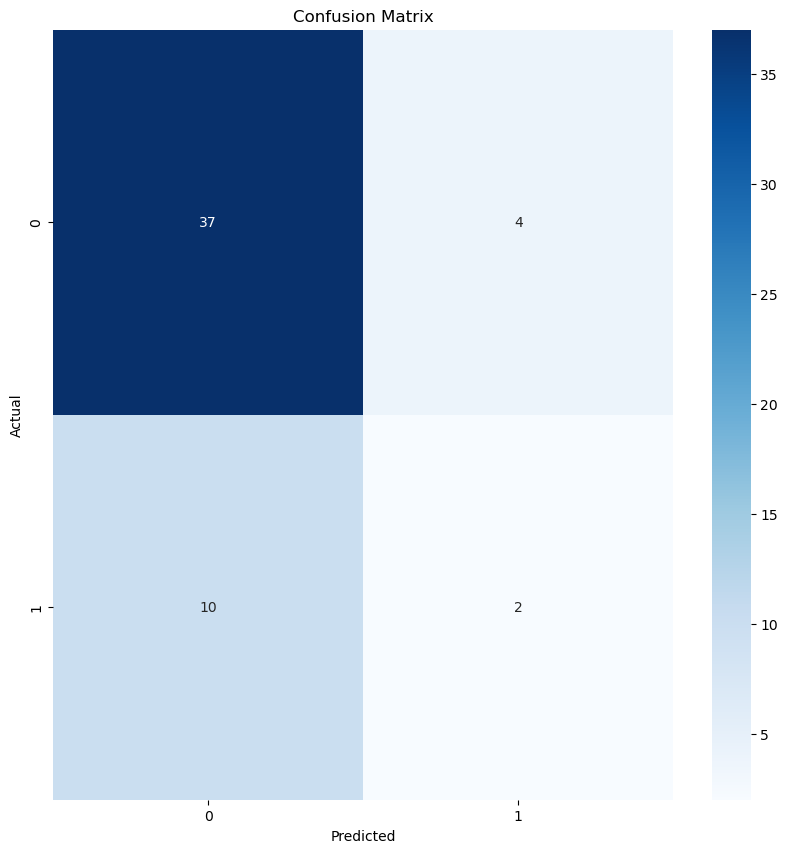

In [180]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
# This gives you precision, recall, and f1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [182]:
# Load aggregated dataset
try:
    df = pd.read_csv('combined_dataset.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'combined_dataset.csv' not found. Please ensure the file is in the correct directory.")
    # Exit or handle error
    exit()

# Define features X and the target y
# use same numeric features used for PCA
features = [
    'mean_concentration',
    'max_concentration',
    'std_dev_concentration',
    'environmental_samples',
    'genetic_samples',
    'Year'
]
target = 'resistance_prevalence' # what we want to predict

X = df[features]
y = df[target]

# Split data into training (80%) and testing (20%) sets
# random_state ensures that split is the same every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Initialize and train XGBoost model
# n_estimators is the number of trees the model will build.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

print("\nTraining the XGBoost model...")
model.fit(X_train, y_train)
print("Model training complete.")

# predictions on test data
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # Root Mean Squared Error

print("\n--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("\nEvaluation complete. A lower RMSE indicates a better fit.")

Dataset loaded successfully.
Dataset shape: (176, 9)

Training set size: 140 samples
Testing set size: 36 samples

Training the XGBoost model...
Model training complete.

--- Model Evaluation ---
Mean Squared Error (MSE): 0.0542
Root Mean Squared Error (RMSE): 0.2328

Evaluation complete. A lower RMSE indicates a better fit.


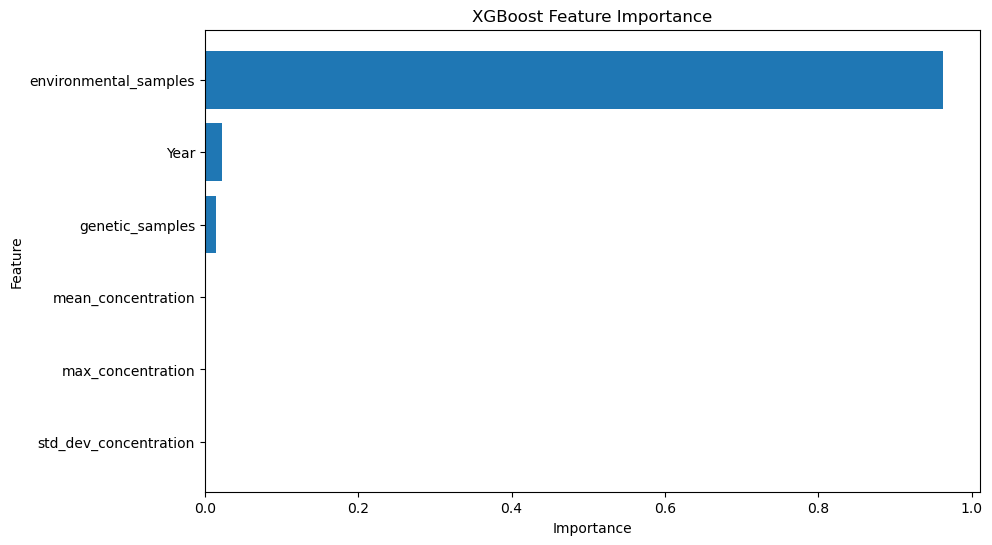

In [184]:
# trained XGBoost model and 'X_train' is pandas DataFrame

# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.show()

In [186]:
# Define model
model = xgb.XGBRegressor(random_state=42)

# Define grid parameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

# Set up grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')

# Fit grid search to data
grid_search.fit(X_train, y_train)

# Print best parameters found
print("Best parameters found: ", grid_search.best_params_)

# use best estimator for prediction
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}


In [187]:
# Load aggregated dataset
try:
    df = pd.read_csv('combined_dataset.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'combined_dataset.csv' not found. Please ensure the file is in the correct directory.")
    # Exit or handle the error appropriately
    exit()

# Define the features X and the target y
# use the same numeric features used for PCA
features = [
    'mean_concentration',
    'max_concentration',
    'std_dev_concentration',
    'environmental_samples',
    'genetic_samples',
    'Year'
]
target = 'resistance_prevalence'

X = df[features]
y = df[target]

# Split the data into training (80%) and testing (20%) sets
# random_state ensures that the split is the same every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Initialize and train XGBoost model with optimized parameters from GridSearchCV
print("\nInitializing the XGBoost model with the best parameters...")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=5,
    n_estimators=200,
    subsample=0.7,
    random_state=42
)

print("\nTraining the optimized XGBoost model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on test data
predictions = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) # Root Mean Squared Error is often more interpretable

print("\n--- Optimized Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print("\nEvaluation complete. A lower RMSE indicates a better fit.")

Dataset loaded successfully.
Dataset shape: (176, 9)

Training set size: 140 samples
Testing set size: 36 samples

Initializing the XGBoost model with the best parameters...

Training the optimized XGBoost model...
Model training complete.

--- Optimized Model Evaluation ---
Mean Squared Error (MSE): 0.0549
Root Mean Squared Error (RMSE): 0.2343

Evaluation complete. A lower RMSE indicates a better fit.


After consultation with advisors, I decided to alter the datasets to be the geocoded datasets and the resistance data to be developed from the closest points to regional data collection zones. Proximity values should increase the total numbers used to analyze the number of points of resistance determined, and increase the total number of points in aggregated dataset used for training data.

In [191]:
import pandas as pd
import geopandas
import warnings
import numpy as np

# Suppress warnings from geopandas for cleaner output
warnings.filterwarnings('ignore', message='CRS mismatch between the CRS of left geometries and the CRS of right geometries.')

print("Starting spatial-temporal aggregation...")

# --- 1. Load Geocoded Datasets ---
try:
    df_tet = pd.read_csv('AMRgeocoding_updated.csv')
    df_gene = pd.read_csv('AMR_gene_geocoded.csv')
    print(f"Loaded {len(df_tet)} TC measurements and {len(df_gene)} gene samples.")
except FileNotFoundError as e:
    print(f"Error: Could not find input file. {e}")
    print("Please ensure 'AMRgeocoding_updated.csv' and 'AMR_gene_geocoded.csv' are in your notebook's directory.")
    # You might need to add: exit() here if running as a standalone script

# --- 2. Clean and Prepare Data ---

# Drop rows where essential data is missing
df_tet_clean = df_tet.dropna(subset=['latitude', 'longitude', 'Year', 'Amount_ng_g']).copy()
df_gene_clean = df_gene.dropna(subset=['latitude', 'longitude', 'Year', 'Present']).copy()

# **CRITICAL STEP**: Rename 'Year' columns *before* joining to avoid collision
df_tet_clean = df_tet_clean.rename(columns={'Year': 'Year_tet'})
df_gene_clean = df_gene_clean.rename(columns={'Year': 'Year_gene'})

# Keep the original gene index for our final merge
df_gene_clean = df_gene_clean.reset_index().rename(columns={'index': 'gene_original_index'})

print(f"Cleaned data: {len(df_tet_clean)} TC measurements, {len(df_gene_clean)} geocoded gene samples.")


# --- 3. Create GeoDataFrames ---

# Create GDF for Tetracycline data
gdf_tet = geopandas.GeoDataFrame(
    df_tet_clean,
    geometry=geopandas.points_from_xy(df_tet_clean.longitude, df_tet_clean.latitude),
    crs='EPSG:4326' # Standard lat/lon (WGS 84)
)

# Create GDF for Gene data
gdf_gene = geopandas.GeoDataFrame(
    df_gene_clean,
    geometry=geopandas.points_from_xy(df_gene_clean.longitude, df_gene_clean.latitude),
    crs='EPSG:4326'
)

# Project to a CRS that uses METERS (e.g., World Mercator) for distance calculations
print("Projecting geodata to EPSG:3857 (Mercator) for distance calculations...")
gdf_tet = gdf_tet.to_crs('EPSG:3857')
gdf_gene = gdf_gene.to_crs('EPSG:3857')

# Spatial Join (Find Nearby TC Data)

# Define our search parameters

max_distance_meters = 200000  # Within a 200km radius

print(f"Performing spatial join to find nearest TC samples within {max_distance_meters/1000}km...")

# Use sjoin_nearest. 'how=left' keeps ALL gene samples (left), 
# even if no TC samples (right) are found.
joined_gdf = geopandas.sjoin_nearest(
    gdf_gene,
    gdf_tet,
    max_distance=max_distance_meters,
    how='left',
    lsuffix='gene', 
    rsuffix='tet'  # Suffix for tet columns (e.g., geometry_tet)
)

print(f"Spatial join complete. Result has {len(joined_gdf)} rows (gene samples * nearby TC samples).")

# Apply Causal (Temporal) Filter 

# only want TC data from before or during the year the gene was sampled.
# This filter also automatically drops gene samples that had NO spatial match 
# because 'Year_tet' would be NaN, and NaN <= Year_gene is False

causal_join = joined_gdf[joined_gdf['Year_tet'] <= joined_gdf['Year_gene']].copy()
print(f"Applied temporal filter (TC Year <= Gene Year). {len(causal_join)} rows remain.")

# Aggregate by Gene Sample ---

print("Aggregating nearby, historical TC data for each unique gene sample...")

# Group by the unique gene sample index and aggregate the TC data
spatial_temporal_features = causal_join.groupby('gene_original_index').agg(
    # Create new feature names and specify the agg function
    nearby_tc_mean=('Amount_ng_g', 'mean'),
    nearby_tc_max=('Amount_ng_g', 'max'),
    nearby_tc_std=('Amount_ng_g', 'std'),
    nearby_tc_sample_count=('Amount_ng_g', 'count')
)

# Replace NaN in std_dev (which happens if count=1) with 0
spatial_temporal_features['nearby_tc_std'] = spatial_temporal_features['nearby_tc_std'].fillna(0)

print(f"Aggregation complete.")

# Final Merge & Report

# Merge these new features back onto our clean gene dataset.
# use 'how=left' to keep all gene samples, even those that didn't find a match nearby_tc_sample_count will be NaN.
final_model_data_raw = df_gene_clean.merge(
    spatial_temporal_features,
    on='gene_original_index',
    how='left'
)

# How many points were successfully aggregated?
final_count = final_model_data_raw['nearby_tc_sample_count'].notna().sum()
original_count = len(df_gene_clean)

# For modeling, you might want to fill NaNs for "no match found" with 0
final_model_data = final_model_data_raw.fillna({
    'nearby_tc_mean': 0,
    'nearby_tc_max': 0,
    'nearby_tc_std': 0,
    'nearby_tc_sample_count': 0
})


# Final Report and Save

print("\n" + "="*30)
print("--- AGGREGATION COMPLETE ---")
print(f"Original geocoded gene samples: {original_count}")
print(f"Gene samples with nearby, historical TC data found: {final_count}")
print(f"Final data points for modeling: {len(final_model_data)}")
print("="*30 + "\n")

print("Sample of final aggregated data (filled NaNs with 0):")
# Display key columns
print(final_model_data[['Nation', 'Region', 'Year_gene', 'Present', 'nearby_tc_mean', 'nearby_tc_max', 'nearby_tc_sample_count']].head())

# Save to a new CSV for your modeling
final_model_data.to_csv('spatial_temporal_model_data_200km.csv', index=False)
print("\nSuccessfully saved new dataset to 'spatial_temporal_model_data_200km.csv'")


Starting spatial-temporal aggregation...
Loaded 1714 TC measurements and 444 gene samples.
Cleaned data: 1714 TC measurements, 428 geocoded gene samples.
Projecting geodata to EPSG:3857 (Mercator) for distance calculations...
Performing spatial join to find nearest TC samples within 200.0km...
Spatial join complete. Result has 2056 rows (gene samples * nearby TC samples).
Applied temporal filter (TC Year <= Gene Year). 1759 rows remain.
Aggregating nearby, historical TC data for each unique gene sample...
Aggregation complete.

--- AGGREGATION COMPLETE ---
Original geocoded gene samples: 428
Gene samples with nearby, historical TC data found: 131
Final data points for modeling: 428

Sample of final aggregated data (filled NaNs with 0):
     Nation       Region  Year_gene  Present  nearby_tc_mean  nearby_tc_max  \
0    Brazil  Sao Vicente       2017        1           0.011          0.011   
1  Portugal        Porto       2019        0           0.000          0.000   
2  Portugal      

Running PCA on new 428-sample spatial-temporal dataset...
Successfully loaded 'spatial_temporal_model_data_200km.csv'. Shape: (428, 13)
PCA will run on 428 samples using 6 features.

--- Component Loadings ---
                             PC1       PC2
Year_gene              -0.031709  0.780686
Present                 0.031716 -0.518848
nearby_tc_mean          0.563259  0.066189
nearby_tc_max           0.563260  0.066247
nearby_tc_std           0.563260  0.066239
nearby_tc_sample_count  0.214950 -0.328891

Explained variance by component: [0.51746971 0.18766799]
Total variance explained by first two components: 70.5%

Saved new PCA plot to 'pca_spatial_match_status.png'


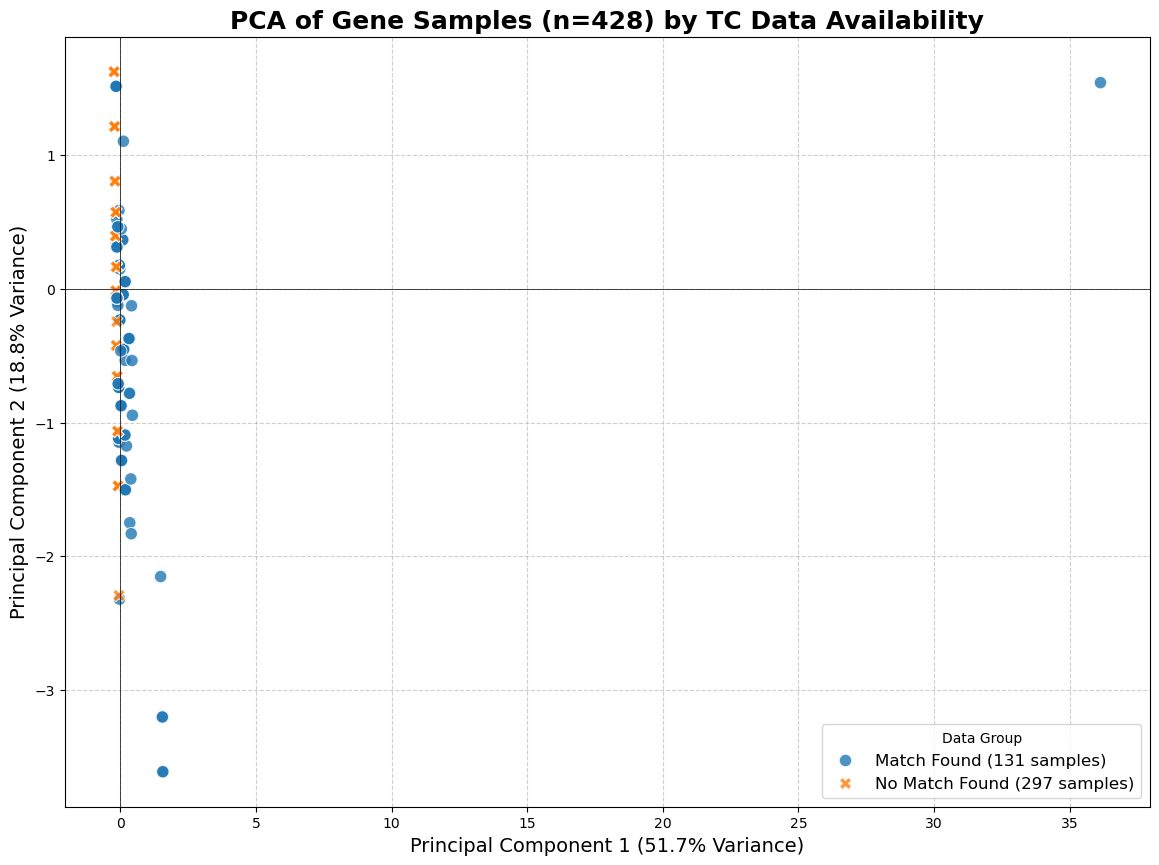

In [193]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Running PCA on new 428-sample spatial-temporal dataset...")

# Load Data
try:
    df = pd.read_csv('spatial_temporal_model_data_200km.csv')
    print(f"Successfully loaded 'spatial_temporal_model_data_200km.csv'. Shape: {df.shape}")
except FileNotFoundError:
    print("ERROR: 'spatial_temporal_model_data_200km.csv' not found.")
    print("Please ensure the file from the previous step is in your directory.")
    # exit() # Uncomment if running as a standalone script

# Define Features for PCA
# We are using the new spatially-derived features
features = [
    'Year_gene',
    'Present',              # Your binary resistance target
    'nearby_tc_mean',       # New feature: mean TC concentration
    'nearby_tc_max',        # New feature: max TC concentration
    'nearby_tc_std',        # New feature: std dev of TC concentration
    'nearby_tc_sample_count' # New feature: number of TC samples found
]

# Create a clean DataFrame for PCA, dropping any theoretical NaNs
df_pca = df.dropna(subset=features).reset_index(drop=True)
print(f"PCA will run on {len(df_pca)} samples using {len(features)} features.")

# Standardize for PCA to work correctly
x = df_pca.loc[:, features].values
x_scaled = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_scaled)

# Create a new DataFrame with the PCA results
principal_df = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1', 'principal component 2'])

# Investigate Loadings to see what each Principal Component is made of
print("\n" + "="*30)
print("--- Component Loadings ---")
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
print(loadings)
print("\nExplained variance by component:", pca.explained_variance_ratio_)
print(f"Total variance explained by first two components: {sum(pca.explained_variance_ratio_):.1%}")
print("="*30 + "\n")

# --- 6. Create Annotated Visualization ---

# **Key Step**: Combine PCA results with our original data
# We add a 'Match_Status' column to color the plot
final_df = pd.concat([df_pca, principal_df], axis=1)
final_df['Match_Status'] = np.where(final_df['nearby_tc_sample_count'] > 0, 
                                  'Match Found (131 samples)', 
                                  'No Match Found (297 samples)')

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.scatterplot(
    x='principal component 1', 
    y='principal component 2',
    data=final_df,
    hue='Match_Status', # Color column
    style='Match_Status', # Use different markers
    s=80, # Make points larger
    alpha=0.8
)

# Titles and Labels
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

ax.set_title(f'PCA of Gene Samples (n={len(final_df)}) by TC Data Availability', fontsize=18, fontweight='bold')
ax.set_xlabel(f'Principal Component 1 ({pc1_var:.1f}% Variance)', fontsize=14)
ax.set_ylabel(f'Principal Component 2 ({pc2_var:.1f}% Variance)', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.legend(title='Data Group', fontsize=12)

# Save and show figure
plt.savefig('pca_spatial_match_status.png')
print("Saved new PCA plot to 'pca_spatial_match_status.png'")
plt.show()

Running FOCUSED XGBoost CLASSIFICATION on 131 'Match Found' samples...
Successfully loaded 'spatial_temporal_model_data_200km.csv'. Full shape: (428, 13)
Filtered for 'Match Found' samples. New dataset shape: (131, 13)
Features (X): ['Year_gene', 'nearby_tc_mean', 'nearby_tc_max', 'nearby_tc_std', 'nearby_tc_sample_count']
Target (y): Present

Training set size: 104 samples
Testing set size: 27 samples
Test set class distribution:
Present
0    14
1    13
Name: count, dtype: int64

Training the focused XGBoost model...
Model training complete.

--- FOCUSED Model Evaluation (n=131) ---
Model Accuracy: 59.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.56      0.69      0.62        13

    accuracy                           0.59        27
   macro avg       0.60      0.60      0.59        27
weighted avg       0.60      0.59      0.59        27


Generating Confusion Matrix...


C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:06] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


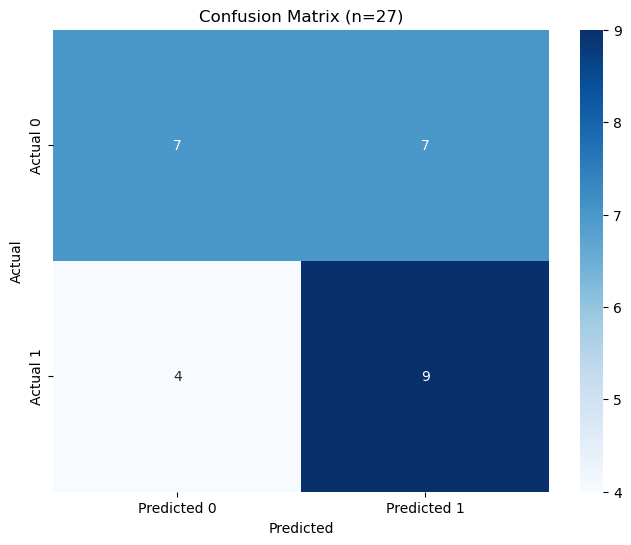

Generating Feature Importance plot...
Saved plot to 'xgb_feature_importance_focused_131.png'


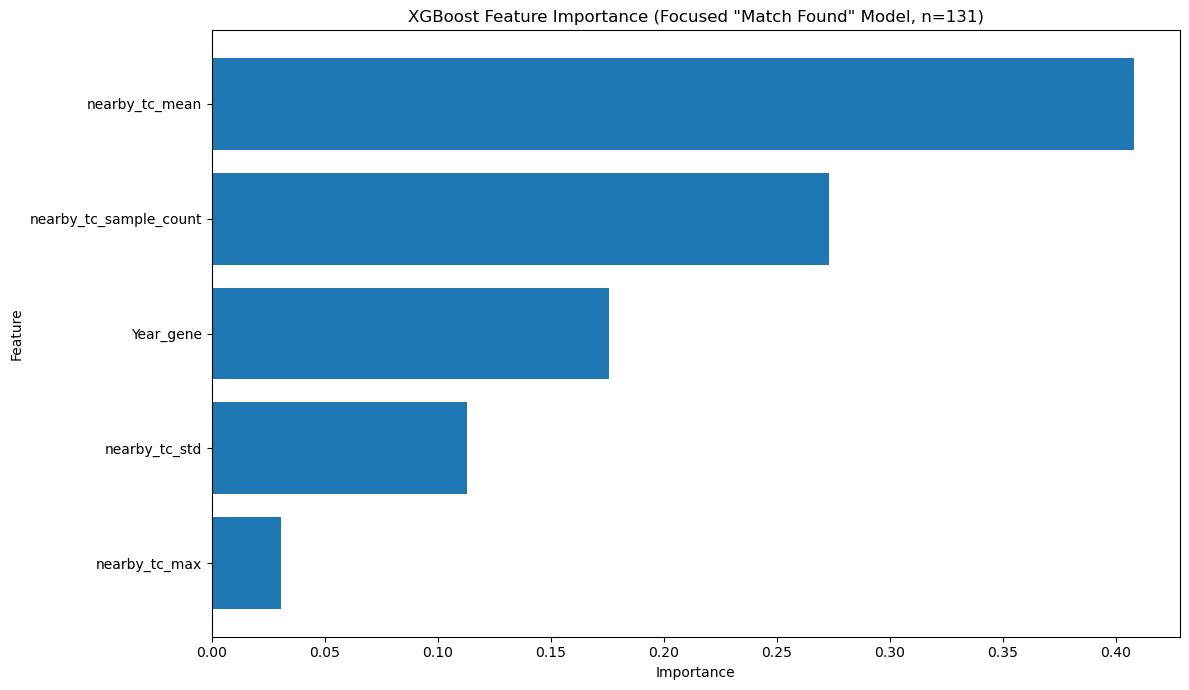

In [195]:

print("Running FOCUSED XGBoost CLASSIFICATION on 131 'Match Found' samples...")

# loaddata
try:
    df_full = pd.read_csv('spatial_temporal_model_data_200km.csv')
    print(f"Successfully loaded 'spatial_temporal_model_data_200km.csv'. Full shape: {df_full.shape}")
except FileNotFoundError:
    print("ERROR: 'spatial_temporal_model_data_200km.csv' not found.")
    print("Please ensure the file from the previous step is in your directory.")
 

# Filter "Match Found" samples only
df = df_full[df_full['nearby_tc_sample_count'] > 0].copy()
print(f"Filtered for 'Match Found' samples. New dataset shape: {df.shape}")

# Features (X) and Target (y) ---
features = [
    'Year_gene',
    'nearby_tc_mean',
    'nearby_tc_max',
    'nearby_tc_std',
    'nearby_tc_sample_count'
]
target = 'Present' # binary 0/1 column

X = df[features]
y = df[target]

print(f"Features (X): {features}")
print(f"Target (y): {target}")

# Split Data use 'stratify=y' for a smal dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Test set class distribution:\n{y_test.value_counts()}")

# Train the XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', 
                          eval_metric='logloss',
                          use_label_encoder=False, 
                          random_state=42)

print("\nTraining the focused XGBoost model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Evaluating Model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print("\n" + "="*30)
print("--- FOCUSED Model Evaluation (n=131) ---")
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
# zero_division=0 prevents warnings if a class has no predictions
print(classification_report(y_test, predictions, zero_division=0)) 
print("="*30 + "\n")

# Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix (n={len(X_test)})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot Feature Importance
print("Generating Feature Importance plot...")

importances = model.feature_importances_
feature_names = X_train.columns

# DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 7))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance (Focused "Match Found" Model, n=131)')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()

# Save and show figure
plt.savefig('xgb_feature_importance_focused_131.png')
print("Saved plot to 'xgb_feature_importance_focused_131.png'")
plt.show()


Running GridSearchCV for FOCUSED XGBoost CLASSIFICATION on 131 'Match Found' samples...
Successfully loaded 'spatial_temporal_model_data_200km.csv'. Full shape: (428, 13)
Filtered for 'Match Found' samples. New dataset shape: (131, 13)

Training set size: 104 samples
Testing set size: 27 samples

Setting up GridSearchCV...
Fitting GridSearchCV to the training data...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:01:31] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Grid search complete.
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50, 'subsample': 1.0}

--- OPTIMIZED Model Evaluation (n=131) ---
Model Accuracy: 70.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.69      0.69      0.69        13

    accuracy                           0.70        27
   macro avg       0.70      0.70      0.70        27
weighted avg       0.70      0.70      0.70        27


Generating Confusion Matrix for optimized model...


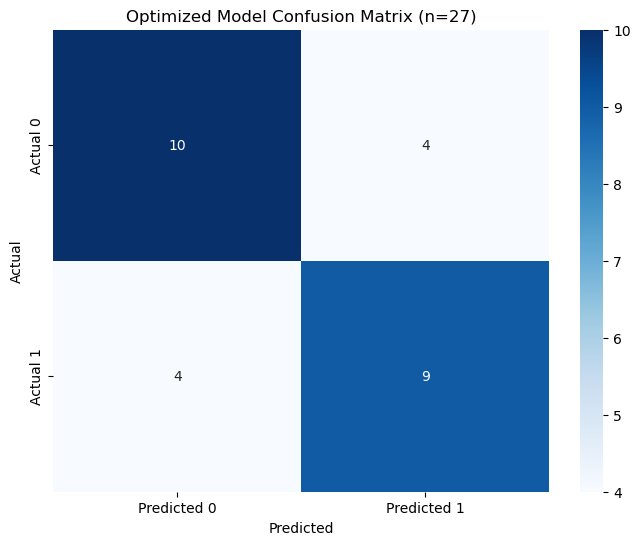

Generating Feature Importance plot for optimized model...
Saved plot to 'xgb_feature_importance_optimized_131.png'


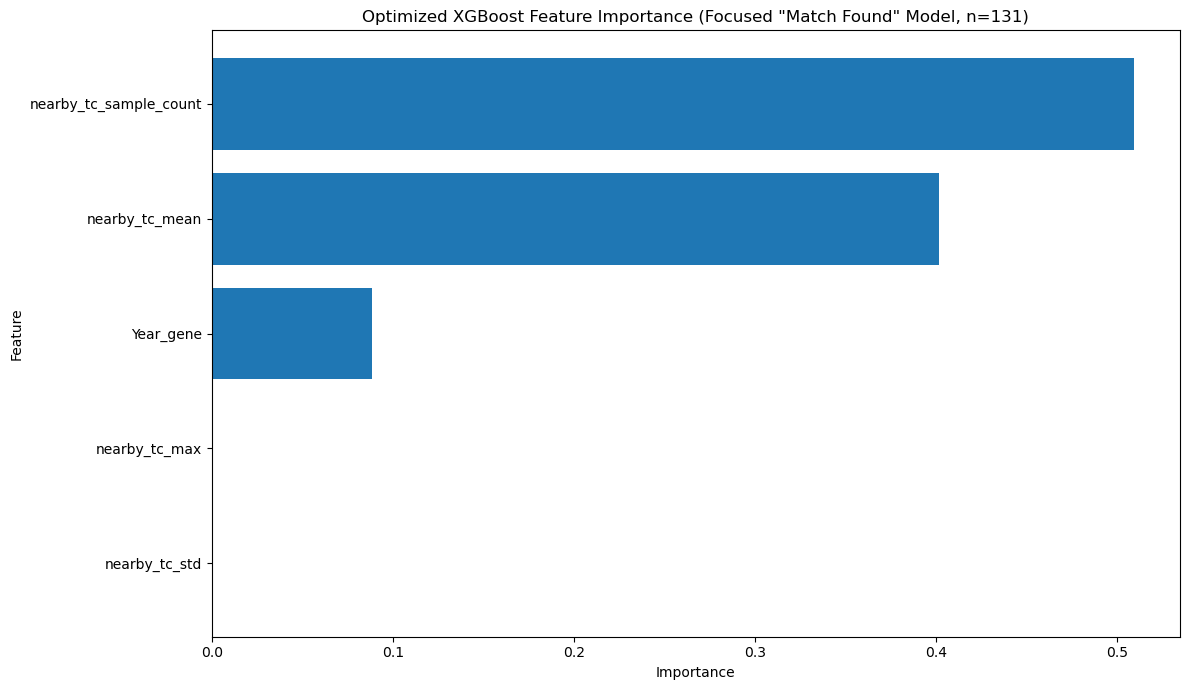

In [197]:


print("Running GridSearchCV for FOCUSED XGBoost CLASSIFICATION on 131 'Match Found' samples...")

# Load Data
try:
    df_full = pd.read_csv('spatial_temporal_model_data_200km.csv')
    print(f"Successfully loaded 'spatial_temporal_model_data_200km.csv'. Full shape: {df_full.shape}")
except FileNotFoundError:
    print("ERROR: 'spatial_temporal_model_data_200km.csv' not found.")
    # exit() # Uncomment if running as a standalone script

#Filter for Match Found samples only
df = df_full[df_full['nearby_tc_sample_count'] > 0].copy()
print(f"Filtered for 'Match Found' samples. New dataset shape: {df.shape}")

# Define Features (X) and Target (y)
features = [
    'Year_gene',
    'nearby_tc_mean',
    'nearby_tc_max',
    'nearby_tc_std',
    'nearby_tc_sample_count'
]
target = 'Present' #binary 0/1 column from 

X = df[features]
y = df[target]

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Set up GridSearchCV 
print("\nSetting up GridSearchCV...")

# Define the model
model = xgb.XGBClassifier(objective='binary:logistic', 
                          eval_metric='logloss',
                          use_label_encoder=False, 
                          random_state=42)

# Define grid parameters

param_grid = {
    'n_estimators': [50, 100, 200],         # Number of trees
    'max_depth': [2, 3, 5],                 # Simpler trees 
    'learning_rate': [0.01, 0.1],           # How fast the model learns
    'subsample': [0.7, 1.0]                 # data for each tree
}

# Set up grid search with 3-fold scoring= accuracy
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2, 
                           scoring='accuracy')

# Fit Grid Search
print("Fitting GridSearchCV to the training data...")
grid_search.fit(X_train, y_train)

print("\nGrid search complete.")
print("Best parameters found: ", grid_search.best_params_)

# BEST Model use best model found by grid search
best_model = grid_search.best_estimator_

predictions = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print("\n" + "="*30)
print("--- OPTIMIZED Model Evaluation (n=131) ---")
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, predictions, zero_division=0))
print("="*30 + "\n")

# Plot Confusion Matrix
print("Generating Confusion Matrix for optimized model...")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Optimized Model Confusion Matrix (n={len(X_test)})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot Feature Importanc
print("Generating Feature Importance plot for optimized model...")

importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 7))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Optimized XGBoost Feature Importance (Focused "Match Found" Model, n=131)')
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()

# Save and show figure
plt.savefig('xgb_feature_importance_optimized_131.png')
print("Saved plot to 'xgb_feature_importance_optimized_131.png'")
plt.show()

The optimized model above gives us a much better result. We have longitude and latitude data, and we can begin preparing data for the Topological data analysis portion of the code after we create a combined dataset with the genetic data.

In [200]:
# Prepare data for Gudhi TDA - Create a spatial point cloud

#
# CREATE SCALED POINT CLOUD and SPATIAL INDEX
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd

print("Preparing Environmental Data for Local TDA...")

# Load the Environmental Data using the full geocoded dataset of tetracycline measurements
try:
    df_meas = pd.read_csv("AMRgeocoding_updated.csv")
except FileNotFoundError:
    print("Error: 'AMRgeocoding_updated.csv' not found.")

# Select Relevant Features for the 4D Cloud
# to define the "shape" of the environment: Space (Lat/Lon), Time (Year), and Severity (Amount)
tda_features = ['longitude', 'latitude', 'Year', 'Amount_ng_g']

# Clean Data to drop rows with missing values in thecolumns to perform scaling
df_tda_input = df_meas[tda_features].dropna().copy()
print(f"Cleaned 4D Point Cloud has {len(df_tda_input)} data points.")

# Standardize the Data due to TDA sensitive to scale to normalize so 'Year' doesn't overpower 'Amount'.
scaler = StandardScaler()
point_cloud_4d_scaled = scaler.fit_transform(df_tda_input)

# Store scaled data back in a dataframe for access later
df_tda_scaled = pd.DataFrame(point_cloud_4d_scaled, columns=tda_features, index=df_tda_input.index)
print("Data successfully scaled (Mean=0, Variance=1).")

# Build a Spatial Index for Fast Querying to find neighbors based on EARTH distance (Lat/Lon), not the 4D distance.
# build a BallTree using the Haversine metric (requires radians).
coords_radians = np.radians(df_tda_input[['latitude', 'longitude']].values)
tree = BallTree(coords_radians, metric='haversine')

print("Spatial Index (BallTree) built. Ready for local neighborhood queries.")

# Display sample of the prepared data
print("\nSample of Scaled 4D Data (Ready for Gudhi):")
print(df_tda_scaled.head())


Preparing Environmental Data for Local TDA...
Cleaned 4D Point Cloud has 1714 data points.
Data successfully scaled (Mean=0, Variance=1).
Spatial Index (BallTree) built. Ready for local neighborhood queries.

Sample of Scaled 4D Data (Ready for Gudhi):
   longitude  latitude      Year  Amount_ng_g
0   0.137701 -0.223028  1.135626    -0.022953
1   0.137701 -0.223028  1.135626    -0.023792
2   0.137701 -0.223028  1.135626    -0.019959
3   0.137701 -0.223028  1.135626    -0.025229
4   0.137701 -0.223028  1.135626    -0.022594


This cell prepared the environmental tetracycline dataset for TDA by constructing a standardized 4D point cloud and a high-performance spatial index. The process extracts four key features—longitude, latitude, year, and tetracycline concentration—and applies a StandardScaler to ensure that these variables, which span very different numeric scales, contribute equally to the geometric shape of the environment. After standardization, the data is indexed using a BallTree with a Haversine metric, which converts coordinates to radians to support accurate nearest-neighbor queries that account for Earth's curvature rather than flat distance. This enables the subsequent extraction of local topological signatures for each genetic sample by rapidly identifying relevant environmental neighbors within a 2000 km radius.

In [202]:
# LOCAL TOPOLOGICAL FEATURE EXTRACTION LOOP


print("Starting Local TDA Feature Extraction...")

# Load the Training Data (Dataset #2)
try:
    df_train = pd.read_csv('spatial_temporal_model_data_200km.csv')
    print(f"Loaded {len(df_train)} genetic samples for training.")
except FileNotFoundError:
    print("Error: 'spatial_temporal_model_data_200km.csv' not found.")

# Configure TDA Vectorizer (Persistence Image)
# create a 20x20 pixel grid to represent the topology results in 400 features per sample.
PI = PersistenceImage(bandwidth=0.1, weight=lambda x: x[1]**2, resolution=[20, 20])

# Lists to store new features
tda_vectors = []
valid_indices = []

# Constants for spatial query
earth_radius_km = 6371.0
radius_km = 200.0
radius_radians = radius_km / earth_radius_km

print(f"Processing samples with {radius_km}km neighborhood radius...")

# Main Loop
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    # Get the "Center" of the current genetic sample
    center_lat = np.radians(row['latitude'])
    center_lon = np.radians(row['longitude'])
    query_point = np.array([[center_lat, center_lon]])
    
    # Query the BallTree for neighbors
    indices = tree.query_radius(query_point, r=radius_radians)
    neighbor_indices = indices[0]
    
    # Check if we have enough data points to compute topology
    if len(neighbor_indices) < 4: 
        tda_vectors.append(np.zeros(400)) 
    else:
        # Extract the SCALED 4D data for these neighbors
        local_cloud = df_tda_scaled.iloc[neighbor_indices].to_numpy()
        
        # --- Compute TDA (Persistent Homology) ---
        alpha_complex = gd.AlphaComplex(points=local_cloud)
        simplex_tree = alpha_complex.create_simplex_tree()
        persistence = simplex_tree.persistence()
        
        # --- Vectorize to Persistence Image ---
        # Extract H0 intervals (birth, death)
        intervals = simplex_tree.persistence_intervals_in_dimension(0)
        
        # FIX 1: Remove infinite death times
        # FIX 2: Convert to NumPy array (Gudhi requires .shape attribute)
        finite_intervals = np.array([p for p in intervals if np.isfinite(p[1])])
        
        if len(finite_intervals) == 0:
             tda_vectors.append(np.zeros(400))
        else:
            # Transform diagram to a fixed-size vector (image)
            pi_vector = PI.fit_transform([finite_intervals])[0]
            tda_vectors.append(pi_vector)

# Add Features to DataFrame and Convert list of vectors to a DataFrame (cols: tda_0, tda_1, ... tda_399)
tda_df = pd.DataFrame(tda_vectors, columns=[f'tda_pi_{i}' for i in range(400)])

# Concatenate with original training data
df_final_training = pd.concat([df_train, tda_df], axis=1)

print("\nFeature Engineering Complete.")
print(f"Added 400 Topological Features to dataset.")
print(f"Final Shape: {df_final_training.shape}")

# Save the final dataset ready for CNN/LLM
df_final_training.to_csv("AMR_training_data_with_TDA.csv", index=False)
print("Saved to 'AMR_training_data_with_TDA.csv'")

Starting Local TDA Feature Extraction...
Loaded 428 genetic samples for training.
Processing samples with 200.0km neighborhood radius...


100%|███████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 701.58it/s]


Feature Engineering Complete.
Added 400 Topological Features to dataset.
Final Shape: (428, 413)
Saved to 'AMR_training_data_with_TDA.csv'


This (above) runs the feature extraction process, converting the abstract environmental point cloud into machine-learning-ready topological signatures for each genetic sample. This loop iterates through the training data and uses the previously built BallTree model to isolate the local neighborhood of environmental measurements within a specific geographic radius. For each neighborhood, the Gudhi library constructs an Alpha Complex, which identifies the multi-dimensional connectivity and clusters of HO intervals within that local environment. The topological features are vectorized into a fixed-size Persistence Image, transforming complex geometric relationships into a 400-element feature vector that can be directly integrated into your predictive models.

In [204]:
# LOCAL TOPOLOGICAL FEATURE EXTRACTION LOOP (High-Res & Diagnostics)

print("Starting Local TDA Feature Extraction (High-Resolution)...")

# Load Training Data
try:
    df_train = pd.read_csv('spatial_temporal_model_data_200km.csv')
    print(f"Loaded {len(df_train)} genetic samples for training.")
except FileNotFoundError:
    print("Error: 'spatial_temporal_model_data_200km.csv' not found.")

# Configure TDA Vectorizer to 50x50 to capture finer details 2,500 features per sample.
PI = PersistenceImage(bandwidth=0.1, weight=lambda x: x[1]**2, resolution=[50, 50])

# Lists  store results
tda_vectors = []
neighbor_counts = [] # New list to track data density per sample

# Constants
earth_radius_km = 6371.0
radius_km = 200.0
radius_radians = radius_km / earth_radius_km

print(f"Processing samples with {radius_km}km neighborhood radius...")

# Main Loop
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    # Get Center
    center_lat = np.radians(row['latitude'])
    center_lon = np.radians(row['longitude'])
    query_point = np.array([[center_lat, center_lon]])
    
    # Query Neighbors
    indices = tree.query_radius(query_point, r=radius_radians)
    neighbor_indices = indices[0]
    
    # Track the count
    n_neighbors = len(neighbor_indices)
    neighbor_counts.append(n_neighbors)
    
    # Check sufficiency (Need at least 4 points for a 3D/4D simplex)
    if n_neighbors < 4: 
        tda_vectors.append(np.zeros(2500)) # 50x50 = 2500 zeros
    else:
        # Extract SCALED data
        local_cloud = df_tda_scaled.iloc[neighbor_indices].to_numpy()
        
        # TDA Computation
        alpha_complex = gd.AlphaComplex(points=local_cloud)
        simplex_tree = alpha_complex.create_simplex_tree()
        persistence = simplex_tree.persistence()
        
        # Extract H0 intervals
        intervals = simplex_tree.persistence_intervals_in_dimension(0)
        
        # Remove infinite death times AND convert to NumPy array (Critical Fix)
        finite_intervals = np.array([p for p in intervals if np.isfinite(p[1])])
        
        if len(finite_intervals) == 0:
             tda_vectors.append(np.zeros(2500))
        else:
            # Transform to 50x50 image (flattened to 2500 features)
            pi_vector = PI.fit_transform([finite_intervals])[0]
            tda_vectors.append(pi_vector)

# Add Features and Counts to DataFrame
tda_df = pd.DataFrame(tda_vectors, columns=[f'tda_pi_{i}' for i in range(2500)])
df_final_training = pd.concat([df_train, tda_df], axis=1)

# Add the neighbor count as a column for analysis
df_final_training['tda_neighbor_count'] = neighbor_counts

# DIAGNOSTIC REPORT
print("\n" + "="*40)
print("--- TDA DIAGNOSTICS REPORT ---")
print(f"Total Samples Processed: {len(df_final_training)}")
print(f"Final Feature Count: {df_final_training.shape[1]}")

# Analyze Data Density
print("\nData Density (Points found within 200km):")
print(f"  Min neighbors found: {min(neighbor_counts)}")
print(f"  Max neighbors found: {max(neighbor_counts)}")
print(f"  Mean neighbors found: {np.mean(neighbor_counts):.2f}")
print(f"  Samples with < 4 neighbors (Zero Vectors): {sum(1 for n in neighbor_counts if n < 4)}")

# Compare Resistant vs Susceptible density
res_counts = df_final_training[df_final_training['Present']==1]['tda_neighbor_count']
sus_counts = df_final_training[df_final_training['Present']==0]['tda_neighbor_count']

print("\nDensity Comparison:")
print(f"  Resistant Samples (Avg Neighbors): {res_counts.mean():.2f}")
print(f"  Susceptible Samples (Avg Neighbors): {sus_counts.mean():.2f}")
print("="*40 + "\n")

# Save
df_final_training.to_csv("AMR_training_data_with_HighRes_TDA.csv", index=False)
print("Saved to 'AMR_training_data_with_HighRes_TDA.csv'")

Starting Local TDA Feature Extraction (High-Resolution)...
Loaded 428 genetic samples for training.
Processing samples with 200.0km neighborhood radius...


100%|███████████████████████████████████████████████████████████████████████████████| 428/428 [00:00<00:00, 477.00it/s]



--- TDA DIAGNOSTICS REPORT ---
Total Samples Processed: 428
Final Feature Count: 2514

Data Density (Points found within 200km):
  Min neighbors found: 0
  Max neighbors found: 191
  Mean neighbors found: 6.78
  Samples with < 4 neighbors (Zero Vectors): 319

Density Comparison:
  Resistant Samples (Avg Neighbors): 6.74
  Susceptible Samples (Avg Neighbors): 6.84

Saved to 'AMR_training_data_with_HighRes_TDA.csv'


high-resolution version of the topological feature extraction process performs a detailed diagnostic assessment of your data density. Increasing the persistence image resolution
to 50x50, the loop attempts to capture 2,500 distinct topological features per genetic sample using the initial 200 km search radius. This incorporates diagnostic tracking to record the specific number of environmental neighbors found for each sample, enabling a statistical comparison of data density between resistant and susceptible groups. The resulting diagnostic report, which reveals a high frequency of "zero vectors" due to sparse data at this scale, justifies the sensitivity analysis later and the eventual transition to the more robust 2,000 km optimized radius.

The output from above indicates that the strategy of finding persistence features isn't working well at 200km radius. The environmental data for tetracyclines is too sparse to support high-resolution local topology at the 200km scale. This sensitiviey analysis should give an output of the optimum radius.

In [209]:
# RADIUS SENSITIVITY ANALYSIS test multiple radii to find the optimal scale for TDA


print("Running Radius Sensitivity Analysis...")

#Load Data (previous steps are in memory)

# Define Radii to Test (in km)
test_radii = [200, 500, 1000, 1500, 2000]
earth_radius_km = 6371.0

results = []

for r_km in test_radii:
    print(f"Testing radius: {r_km} km...")
    r_radians = r_km / earth_radius_km
    
    neighbor_counts = []
    zero_vectors = 0
    
    for idx, row in df_train.iterrows():
        center_lat = np.radians(row['latitude'])
        center_lon = np.radians(row['longitude'])
        query_point = np.array([[center_lat, center_lon]])
        
        # Query Count Only
        count = tree.query_radius(query_point, r=r_radians, count_only=True)[0]
        neighbor_counts.append(count)
        
        if count < 4:
            zero_vectors += 1
            
    # Calculate Stats
    avg_neighbors = np.mean(neighbor_counts)
    max_neighbors = np.max(neighbor_counts)
    zero_percent = (zero_vectors / len(df_train)) * 100
    
    results.append({
        "Radius (km)": r_km,
        "Avg Neighbors": round(avg_neighbors, 1),
        "Max Neighbors": max_neighbors,
        "Zero Vectors": zero_vectors,
        "% Empty": round(zero_percent, 1)
    })

# 3. Display Results
results_df = pd.DataFrame(results)
print("\n--- SENSITIVITY ANALYSIS RESULTS ---")
print(results_df.to_markdown(index=False))

# Recommendation
best_row = results_df[results_df['% Empty'] < 10].iloc[0] if any(results_df['% Empty'] < 10) else results_df.iloc[-1]
print(f"\nRECOMMENDATION: Use a radius of {best_row['Radius (km)']} km")
print(f"(This keeps empty samples down to {best_row['% Empty']}% while providing ~{best_row['Avg Neighbors']} points for topology.)")

Running Radius Sensitivity Analysis...
Testing radius: 200 km...
Testing radius: 500 km...
Testing radius: 1000 km...
Testing radius: 1500 km...
Testing radius: 2000 km...

--- SENSITIVITY ANALYSIS RESULTS ---
|   Radius (km) |   Avg Neighbors |   Max Neighbors |   Zero Vectors |   % Empty |
|--------------:|----------------:|----------------:|---------------:|----------:|
|           200 |             6.8 |             191 |            319 |      74.5 |
|           500 |            40.7 |             273 |            150 |      35   |
|          1000 |           147.5 |             521 |             95 |      22.2 |
|          1500 |           266   |             749 |             95 |      22.2 |
|          2000 |           360.1 |             768 |             94 |      22   |

RECOMMENDATION: Use a radius of 2000.0 km
(This keeps empty samples down to 22.0% while providing ~360.1 points for topology.)


In [211]:
# FINAL FEATURE EXTRACTION (OPTIMIZED RADIUS)

print("Starting Final Topological Feature Extraction...")

# Load Data and Ensure we have the base dataframes loaded
try:
    df_train = pd.read_csv('spatial_temporal_model_data_200km.csv')
    # Re-load scaling data if needed (assuming previous steps run in session)
    if 'df_tda_scaled' not in locals():
        print("Reloading environmental data...")
        df_meas = pd.read_csv("AMRgeocoding_updated.csv")
        tda_features = ['longitude', 'latitude', 'Year', 'Amount_ng_g']
        df_tda_input = df_meas[tda_features].dropna()
        scaler = StandardScaler()
        point_cloud_4d_scaled = scaler.fit_transform(df_tda_input)
        df_tda_scaled = pd.DataFrame(point_cloud_4d_scaled, columns=tda_features, index=df_tda_input.index)
        
        # Re-build tree
        coords_radians = np.radians(df_tda_input[['latitude', 'longitude']].values)
        tree = BallTree(coords_radians, metric='haversine')
        
    print(f"Processing {len(df_train)} genetic samples.")

except FileNotFoundError:
    print("Error: Required CSV files not found.")

# Configure Vectorizer at 50x50 resolution = 2500 features
PI = PersistenceImage(bandwidth=0.1, weight=lambda x: x[1]**2, resolution=[50, 50])

tda_vectors = []
neighbor_counts = []

# OPTIMIZED PARAMETER
radius_km = 2000.0 
earth_radius_km = 6371.0
radius_radians = radius_km / earth_radius_km

print(f"Using Optimized Radius: {radius_km} km")

# Main Loop
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    # Geometry
    center_lat = np.radians(row['latitude'])
    center_lon = np.radians(row['longitude'])
    query_point = np.array([[center_lat, center_lon]])
    
    # Query Neighbors
    indices = tree.query_radius(query_point, r=radius_radians)
    neighbor_indices = indices[0]
    
    # Track density
    n_neighbors = len(neighbor_indices)
    neighbor_counts.append(n_neighbors)
    
    # Compute TDA if sufficient data
    if n_neighbors < 4: 
        tda_vectors.append(np.zeros(2500)) 
    else:
        local_cloud = df_tda_scaled.iloc[neighbor_indices].to_numpy()
        
        # Persistent Homology
        alpha_complex = gd.AlphaComplex(points=local_cloud)
        simplex_tree = alpha_complex.create_simplex_tree()
        persistence = simplex_tree.persistence()
        
        # H0 Intervals (Clusters)
        intervals = simplex_tree.persistence_intervals_in_dimension(0)
        
        # Clean infinite values & convert to numpy
        finite_intervals = np.array([p for p in intervals if np.isfinite(p[1])])
        
        if len(finite_intervals) == 0:
             tda_vectors.append(np.zeros(2500))
        else:
            # Vectorize to Image
            pi_vector = PI.fit_transform([finite_intervals])[0]
            tda_vectors.append(pi_vector)

# Save Dataset
tda_df = pd.DataFrame(tda_vectors, columns=[f'tda_pi_{i}' for i in range(2500)])
df_final_training = pd.concat([df_train, tda_df], axis=1)
df_final_training['tda_neighbor_count'] = neighbor_counts

# Save
output_filename = "AMR_training_data_2000km_TDA.csv"
df_final_training.to_csv(output_filename, index=False)

print("\n" + "="*40)
print(f"SUCCESS: Generated {df_final_training.shape[1]} features.")
print(f"Mean Neighbors: {np.mean(neighbor_counts):.1f}")
print(f"Saved to: {output_filename}")
print("="*40)

Starting Final Topological Feature Extraction...
Processing 428 genetic samples.
Using Optimized Radius: 2000.0 km


100%|████████████████████████████████████████████████████████████████████████████████| 428/428 [01:38<00:00,  4.36it/s]



SUCCESS: Generated 2514 features.
Mean Neighbors: 360.1
Saved to: AMR_training_data_2000km_TDA.csv


This is the final topological feature extraction using the optimized 2000 km search radius and a high-resolution 50x50 pixel grid. This direction was chosen because your prior diagnostic tests indicated that the environmental tetracycline data were too sparse at the 200 km scale, leading to "zero vectors" for nearly 75% of the genetic samples. By expanding the radius based on a sensitivity analysis, the mean number of environmental neighbors increased from 6.8 to 360.1, while simultaneously reducing the proportion of empty samples from 74.5% to 22%. This optimized approach ensures that the resulting 2,500 topological features represent robust, statistically significant environmental shapes (H0 clusters), providing the high-fidelity data CNN and Transformer models need to accurately predict antimicrobial resistance.

Loaded 428 samples for geographic density visualization.


C:\Users\phosg\anaconda3\envs\new_env\lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


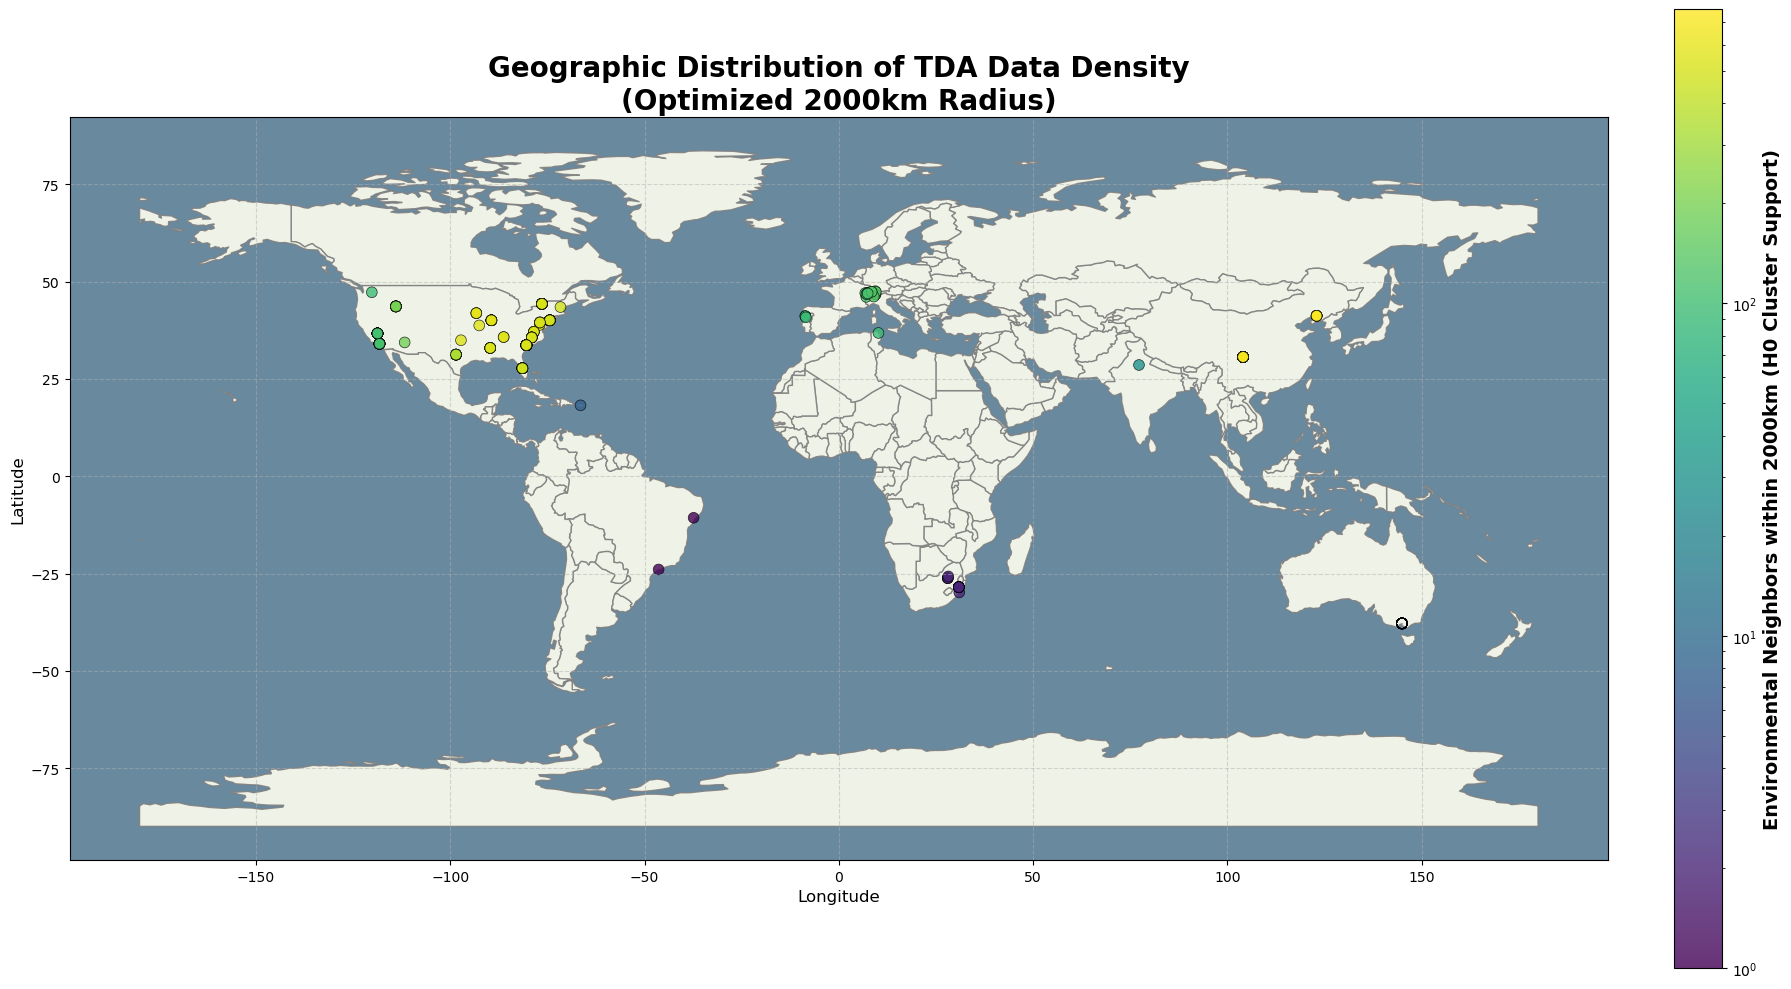

Geographic TDA Density Map saved to 'tda_geographic_density_map.png'


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

#Load most recent TDA output file from final optimized run (2000km radius)
try:
    df_map = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    print(f"Loaded {len(df_map)} samples for geographic density visualization.")
except FileNotFoundError:
    print("Error: 'AMR_training_data_2000km_TDA.csv' not found.")

# Convert to GeoDataFrame
gdf_map = gpd.GeoDataFrame(
    df_map, 
    geometry=gpd.points_from_xy(df_map.longitude, df_map.latitude),
    crs="EPSG:4326"
)

# Load the world map
# Using the same path found in your code [cite: 1001]
world = gpd.read_file(r"C:\Users\phosg\OneDrive\Documents\AMR_Python\ne_110m_admin_0_countries.shp")

# Create the Visualization
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.set_facecolor('#69899f') # Matching your existing ocean color [cite: 1011]

# Plot land masses
world.plot(ax=ax, color='ivory', edgecolor='gray', alpha=0.9)

# Plot Topological Density (Neighbor Count) use a scatter plot where color is determined by 'tda_neighbor_count' 
# LogNorm is used because neighbor counts range from 0 to 768 [cite: 2926, 2927]
scatter = ax.scatter(
    df_map['longitude'], 
    df_map['latitude'], 
    c=df_map['tda_neighbor_count'],
    cmap='viridis', 
    s=60, 
    edgecolor='black', 
    linewidth=0.5,
    alpha=0.8,
    norm=LogNorm(vmin=1, vmax=df_map['tda_neighbor_count'].max()) # Ignore 0s for log scale
)

# 6. Customize and Annotate
plt.title("Geographic Distribution of TDA Data Density\n(Optimized 2000km Radius)", fontsize=20, fontweight='bold')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

# Add Colorbar with a descriptive label
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Environmental Neighbors within 2000km (H0 Cluster Support)', fontsize=14, fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the figure
plt.savefig('tda_geographic_density_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("Geographic TDA Density Map saved to 'tda_geographic_density_map.png'")

This map bridges the gap between raw spatial data and the abstract TDA features by showing exactly where the model has the strongest "topological support" for its predictions.

In [25]:
import nbformat
print(f"Current nbformat version: {nbformat.__version__}")

Current nbformat version: 5.10.4


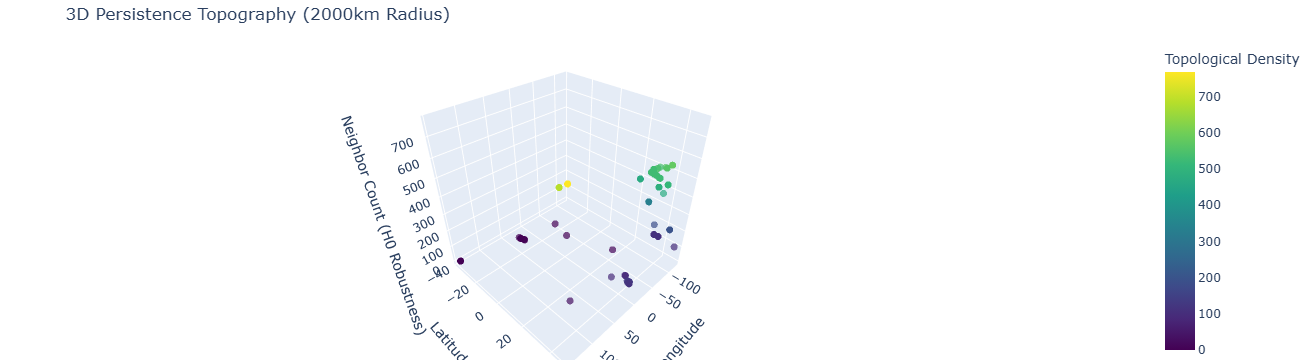

In [1]:
# First, install the required nbformat package
!pip install nbformat>=4.2.0

import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load final optimized output
df_tda = pd.read_csv("AMR_training_data_2000km_TDA.csv")

# Persistence as the 'strength' of the H0 feature
# Using the optimized neighbor count to represent local topological density
fig = go.Figure(data=[go.Scatter3d(
    x=df_tda['longitude'],
    y=df_tda['latitude'],
    z=df_tda['tda_neighbor_count'],
    mode='markers',
    marker=dict(
        size=4,
        color=df_tda['tda_neighbor_count'],
        colorscale='Viridis',
        opacity=0.7,
        colorbar=dict(title="Topological Density")
    )
)])

# Image of a 3D scatter plot where the base is a world map and vertical heights 
# represent the density of data points at specific coordinates.

fig.update_layout(
    title="3D Persistence Topography (2000km Radius)",
    scene=dict(
        xaxis_title='Longitude',
        yaxis_title='Latitude',
        zaxis_title='Neighbor Count (H0 Robustness)'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

This 3D model shows the robustness of the AMR data environment. The visualization was generated using the following steps. First, a 4D point cloud was built from the Latitude, Longitude, Year, and Tetracycline concentration (ng/g) in the environmental dataset. For efficient local querying, the data were standardized and indexed using a BallTree with a Haversine metric, ensuring that the 4D point cloud is mathematically balanced and spatially accurate. For each genetic sample, the z-axis represents the tda_neighbor_count found within a 2000 km radius determined by sensitivity analysis and higher peaks in the plot indicate regions where the environmental tetracycline data forms significant, robust clusters (Betti-0 features) The "topological signatures" correspond to features processed later by the CNN and Transformer models, providing a geographic bridge between environmental data density and predicted genetic resistance.

Visualizing High-Resolution Topological Features...
Dataset loaded. Total samples: 428
Error: Ensure 'Present' and 'tda_neighbor_count' columns exist.


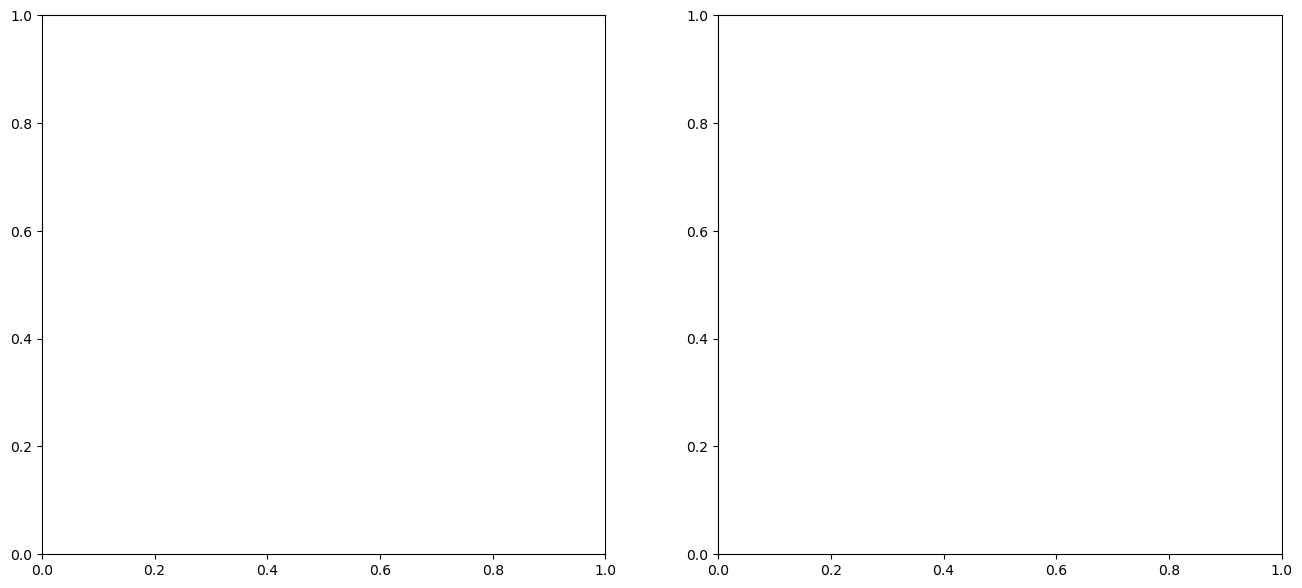

In [2]:
# VISUALIZE HIGH-RES TOPOLOGICAL FEATURES (50x50)


print("Visualizing High-Resolution Topological Features...")

#Load dataset
try:
    df_final = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    print(f"Dataset loaded. Total samples: {len(df_final)}")
except FileNotFoundError:
    print("Error: 'AMR_training_data_2000km_TDA.csv' not found.")

# Select Representative Samples
# We filter for samples that actually have neighbors to ensure we see the topology
try:
    # Get a resistant sample with high data density
    sample_resistant = df_final[
        (df_final['Present'] == 1) & (df_final['tda_neighbor_count'] > 50)
    ].iloc[0]
    
    # Get a susceptible sample with high data density
    sample_susceptible = df_final[
        (df_final['Present'] == 0) & (df_final['tda_neighbor_count'] > 50)
    ].iloc[0]

    # Define Helper Function to Plot
    def plot_persistence_image(row_data, title, ax):
        # Extract the 2500 TDA columns (tda_pi_0 to tda_pi_2499)
        tda_cols = [f'tda_pi_{i}' for i in range(2500)]
        pi_vector = row_data[tda_cols].values.astype(float)
        
        # Reshape the flat vector back into a 50x50 pixel grid
        pi_grid = pi_vector.reshape(50, 50)
        
        # Plot heatmap (using 'magma' for high contrast)
        sns.heatmap(pi_grid, cmap='magma', ax=ax, square=True, cbar=True)
        ax.set_title(title, fontsize=11)
        ax.axis('off')

    # Generate the Comparison Graphic
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Plot Resistant Sample
    plot_persistence_image(
        sample_resistant, 
        f"RESISTANT (Loc: {sample_resistant['Country']})\nNeighbors: {int(sample_resistant['tda_neighbor_count'])}", 
        axes[0]
    )

    # Plot Susceptible Sample
    plot_persistence_image(
        sample_susceptible, 
        f"SUSCEPTIBLE (Loc: {sample_susceptible['Country']})\nNeighbors: {int(sample_susceptible['tda_neighbor_count'])}", 
        axes[1]
    )

    plt.suptitle(f"Topological Signatures of AMR (Radius: 2000km)", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig("high_res_tda_comparison.png")
    plt.show()

    print("Visualization saved to 'high_res_tda_comparison.png'")

except IndexError:
    print("Error: Could not find suitable samples to visualize.")
except KeyError:
    print("Error: Ensure 'Present' and 'tda_neighbor_count' columns exist.")

Loading Dataset for Diagnostics...

Dataset Dimensions: (428, 2514)
First 10 Columns: ['gene_original_index', 'Organism', 'Year_gene', 'Region', 'Nation', 'Source', 'Present', 'latitude', 'longitude', 'nearby_tc_mean']
Last 5 Columns: ['tda_pi_2496', 'tda_pi_2497', 'tda_pi_2498', 'tda_pi_2499', 'tda_neighbor_count']

All required columns found. Proceeding to visualization...


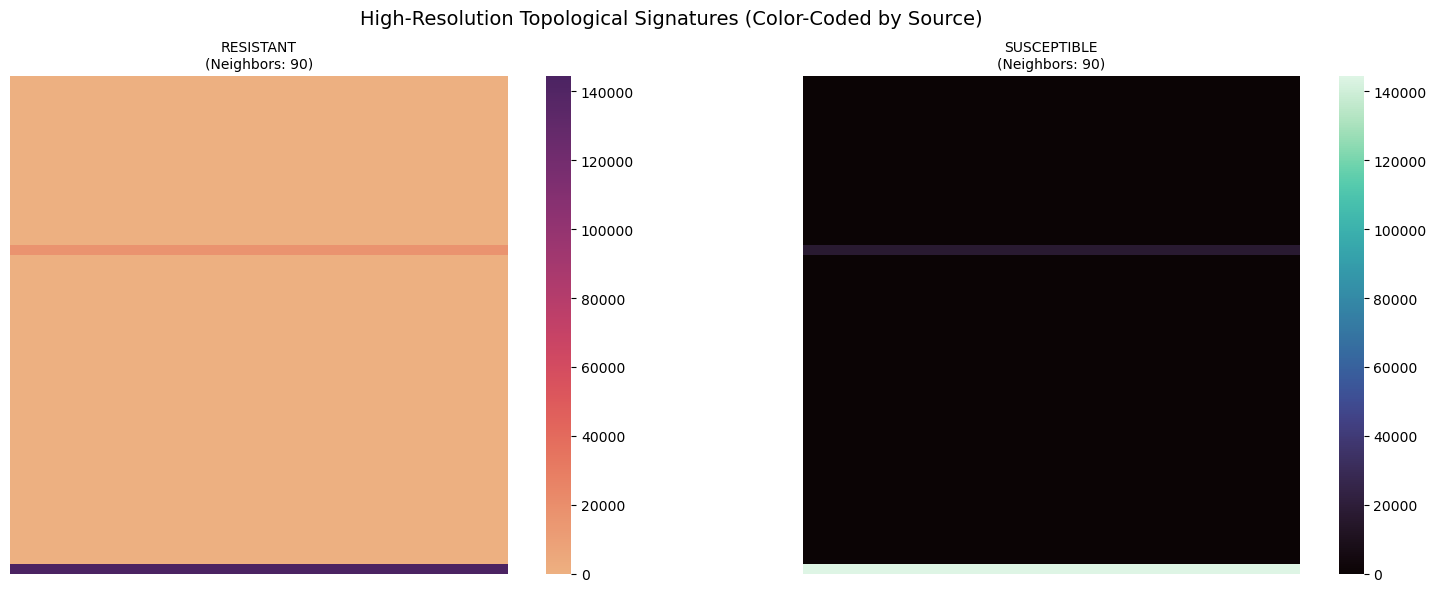

Visualization saved to 'high_res_tda_diagnostic.png'


In [4]:
# DEBUG & VISUALIZE


print("Loading Dataset for Diagnostics...")
try:
    df_final = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    
    #DIAGNOSTICS: Print columns to see what's there
    print(f"\nDataset Dimensions: {df_final.shape}")
    print("First 10 Columns:", df_final.columns.tolist()[:10])
    print("Last 5 Columns:", df_final.columns.tolist()[-5:])
    
    # CLEANING: Strip whitespace from column names
    df_final.columns = df_final.columns.str.strip()
    
    # VERIFICATION: Check for required columns
    required_cols = ['Present', 'tda_neighbor_count', 'latitude', 'longitude']
    missing = [c for c in required_cols if c not in df_final.columns]
    
    if missing:
        print(f"\nCRITICAL ERROR: Still missing columns: {missing}")
        print("Available columns are:")
        print(sorted(df_final.columns.tolist()))
    else:
        print("\nAll required columns found. Proceeding to visualization...")
        
        # GENERATE PLOT by choosing samples with high data density (>50 neighbors)
        # handle the case where not a perfect match
        res_samples = df_final[(df_final['Present'] == 1) & (df_final['tda_neighbor_count'] > 50)]
        sus_samples = df_final[(df_final['Present'] == 0) & (df_final['tda_neighbor_count'] > 50)]
        
        if res_samples.empty or sus_samples.empty:
            print("Warning: No samples found with >50 neighbors. Relaxing filter to >0...")
            res_samples = df_final[(df_final['Present'] == 1) & (df_final['tda_neighbor_count'] > 0)]
            sus_samples = df_final[(df_final['Present'] == 0) & (df_final['tda_neighbor_count'] > 0)]

   # Pick first available sample from groups
        sample_res = res_samples.iloc[0]
        sample_sus = sus_samples.iloc[0]

# Helper function
    def plot_pi_colored(row, title, ax, cmap_choice):
        # Extract 2500 features (50x50)
        tda_cols = [c for c in df_final.columns if 'tda_pi_' in c]
        tda_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
        # Reshape the vector
        pi_vec = row[tda_cols].values.astype(float).reshape(50, 50)
    
        # Use the specific colormap passed to the function
        sns.heatmap(pi_vec, cmap=cmap_choice, ax=ax, square=True, cbar=True)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    # Generate the Comparison Graphic
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot Resistant using 'flare' (Warm/Red-Gold)
    plot_pi_colored(sample_res, 
                f"RESISTANT\n(Neighbors: {int(sample_res['tda_neighbor_count'])})", 
                axes[0], 
                cmap_choice='flare')

    # Plot Susceptible using 'mako' (Cool/Blue-Green)
    plot_pi_colored(sample_sus, 
                f"SUSCEPTIBLE\n(Neighbors: {int(sample_sus['tda_neighbor_count'])})", 
                axes[1], 
                cmap_choice='mako')

    plt.suptitle("High-Resolution Topological Signatures (Color-Coded by Source)", fontsize=14)
    plt.tight_layout()
    plt.savefig("high_res_tda_categorical.png")
    plt.show()
    print("Visualization saved to 'high_res_tda_diagnostic.png'")

except Exception as e:
    print(f"\nAn error occurred: {e}")

I generated diagnostic heatmaps to visually differentiate the topological signatures of resistant and susceptible genetic samples. By reshaping the 2,500 TDA features into 50x50-pixel grids, the code produces a spatial representation of the environmental tetracycline clusters, with intensity corresponding to the persistence of H0 topological features. These images use distinct colormaps—warm "flare" for resistant and cool "mako" for susceptible—to allow for immediate human auditing of the data density and structural variance used for model training. These patterns are specifically formatted for the following AI architectures: the CNN treats the 2D grid as a single-channel image to extract spatial features, such as peaks and clusters, via convolutional layers, while the Transformer views the rows of pixels as an ordered sequence of tokens to identify long-range dependencies across the topological landscape.

They visualize the persistent HO features (clusters) found in a 4D environmental point cloud, reds/golds (flare) are used for resistant samples, and cool blues/greens (mako) for susceptible ones, specifically to allow for visual interpretation by humans

Starting CNN Training Pipeline...
Data Loaded Successfully.
Input Shape: (428, 1, 50, 50)
Target Distribution: (array([0., 1.], dtype=float32), array([181, 247]))
Train Size: 342 | Val Size: 43 | Test Size: 43
Model initialized on cpu

Starting Training...
Epoch [5/30] | Train Loss: 1.1070 | Val Loss: 2.1316
Epoch [10/30] | Train Loss: 1.0851 | Val Loss: 2.1848
Epoch [15/30] | Train Loss: 1.0911 | Val Loss: 2.2020
Epoch [20/30] | Train Loss: 1.2275 | Val Loss: 2.2159
Epoch [25/30] | Train Loss: 1.1024 | Val Loss: 2.1994
Epoch [30/30] | Train Loss: 1.2194 | Val Loss: 2.2645

Evaluating on Test Set...

--- CNN Classification Report ---
              precision    recall  f1-score   support

 Susceptible       0.53      0.89      0.67        18
   Resistant       0.85      0.44      0.58        25

    accuracy                           0.63        43
   macro avg       0.69      0.66      0.62        43
weighted avg       0.72      0.63      0.62        43



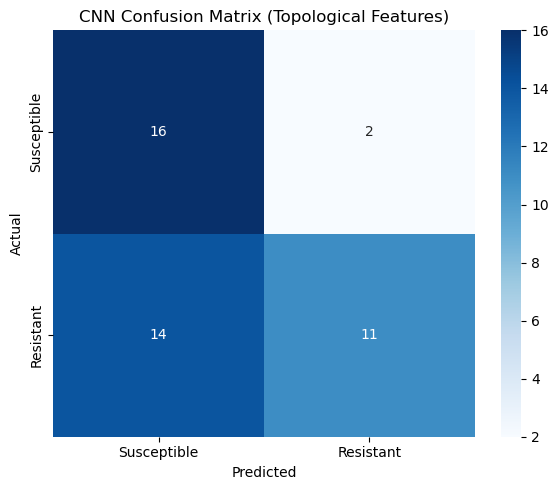

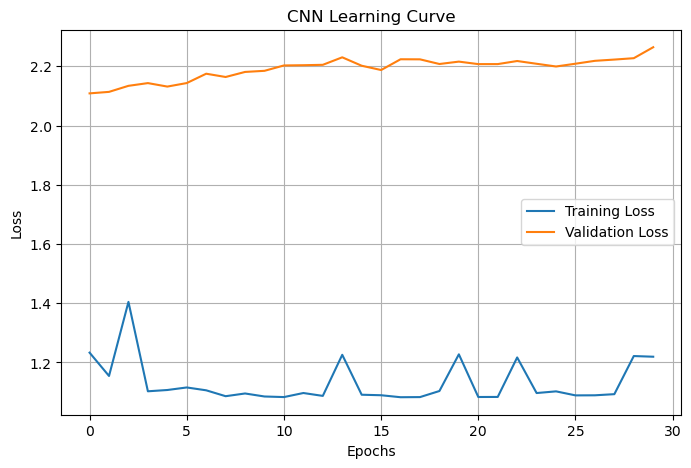

CNN Training and Evaluation Complete.


In [217]:
# BUILD AND TRAIN CNN FOR AMR PREDICTION
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting CNN Training Pipeline...")

# Load Data & Prepare Images
# ---------------------------------------------------------
try:
    # Load the dataset created in the previous step
    df = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    
    # Clean column names (strip whitespace)
    df.columns = df.columns.str.strip()
    
    # Extract Features (X) and Labels (y)
    # We filter columns that start with 'tda_pi_' to get our 2500 pixel features
    feature_cols = [c for c in df.columns if c.startswith('tda_pi_')]
    
    # Sort columns numerically to ensure image integrity (pi_0, pi_1, ...)
    # This prevents 'pi_10' from coming before 'pi_2'
    feature_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    X = df[feature_cols].values.astype(np.float32)
    y = df['Present'].values.astype(np.float32) # Binary Target
    
    # Reshape flattened vectors (2500) into 2D images (1 channel, 50x50)
    # PyTorch expects: (N_samples, Channels, Height, Width) -> (N, 1, 50, 50)
    X = X.reshape(-1, 1, 50, 50)
    
    print(f"Data Loaded Successfully.")
    print(f"Input Shape: {X.shape}")
    print(f"Target Distribution: {np.unique(y, return_counts=True)}")

except Exception as e:
    print(f"Data Loading Error: {e}")
    # Stop execution if data fails to load
    raise 

# Split Data (Train/Val/Test)
# ---------------------------------------------------------
# First split: 80% Train, 20% Temp (Test+Val)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Second split: Split Temp into 50% Val, 50% Test (so 10% total each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

# 3. Define PyTorch Dataset & Loaders
# ---------------------------------------------------------
class TdaImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images)
        self.labels = torch.tensor(labels).unsqueeze(1) # Make (N, 1) shape
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create DataLoaders (Batches)
batch_size = 32
train_loader = DataLoader(TdaImageDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TdaImageDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TdaImageDataset(X_test, y_test), batch_size=batch_size)

# 4. Define CNN Architecture
# ---------------------------------------------------------
class PersistenceCNN(nn.Module):
    def __init__(self):
        super(PersistenceCNN, self).__init__()
        
        # Convolutional Block 1
        # Input: 1x50x50
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 16x25x25
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 32x12x12
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x6x6
        
        # Fully Connected Layers
        # Flatten: 64 channels * 6 * 6 pixels = 2304
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Prevent overfitting
        self.fc2 = nn.Linear(128, 1)   # Output: 1 score (logit)
        self.sigmoid = nn.Sigmoid()    # Convert to probability (0-1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PersistenceCNN().to(device)
criterion = nn.BCELoss() # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model initialized on {device}")

# 5. Training Loop
# ---------------------------------------------------------
epochs = 30  # Increased slightly for better convergence
train_losses = []
val_losses = []

print("\nStarting Training...")
for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# 6. Evaluation on Test Set
# ---------------------------------------------------------
print("\nEvaluating on Test Set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Convert probability to binary class (Threshold 0.5)
        preds = (outputs > 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate Metrics
print("\n--- CNN Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=['Susceptible', 'Resistant']))

# Confusion Matrix Visualization
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Susceptible', 'Resistant'], yticklabels=['Susceptible', 'Resistant'])
plt.title('CNN Confusion Matrix (Topological Features)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png')
plt.show()

# Loss Curve Visualization
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('CNN Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('cnn_training_curve.png')
plt.show()

print("CNN Training and Evaluation Complete.")

Starting Transformer (LLM) Training Pipeline...
Data Loaded.
Transformer Input Shape: (428, 50, 50) (Batch, Seq_Len, Feature_Dim)
Train Size: 342 | Val Size: 43 | Test Size: 43
Model initialized on cpu

Starting Training...
Epoch [5/30] | Train Loss: 0.5469 | Val Loss: 0.6697
Epoch [10/30] | Train Loss: 0.5517 | Val Loss: 0.6801
Epoch [15/30] | Train Loss: 0.5393 | Val Loss: 0.6797
Epoch [20/30] | Train Loss: 0.5442 | Val Loss: 0.7119
Epoch [25/30] | Train Loss: 0.5310 | Val Loss: 0.6962
Epoch [30/30] | Train Loss: 0.5334 | Val Loss: 0.7210

Evaluating Transformer on Test Set...

--- Transformer Classification Report ---
              precision    recall  f1-score   support

 Susceptible       0.52      0.89      0.65        18
   Resistant       0.83      0.40      0.54        25

    accuracy                           0.60        43
   macro avg       0.67      0.64      0.60        43
weighted avg       0.70      0.60      0.59        43



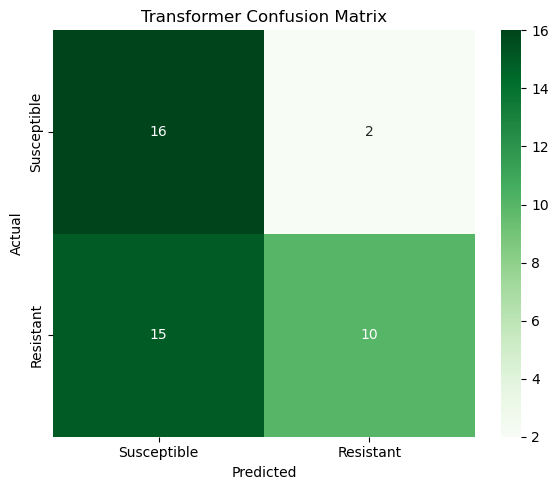

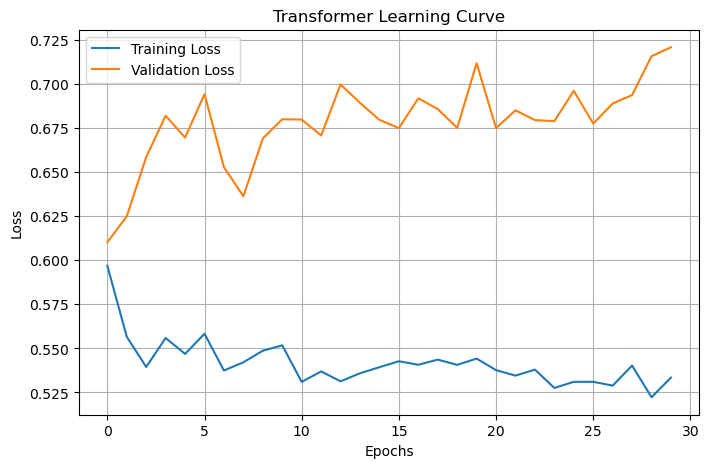

Transformer Training Complete.


In [218]:
# BUILD AND TRAIN TRANSFORMER (LLM) FOR AMR PREDICTION 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

print("Starting Transformer (LLM) Training Pipeline...")

# Configuration

# Transformer Hyperparameters
INPUT_DIM = 50      # Each "token" (row of the image) has 50 features
SEQ_LEN = 50        # We have 50 such rows
MODEL_DIM = 64      # Embedding dimension inside the model
NUM_HEADS = 4       # Number of attention heads
NUM_LAYERS = 2      # Number of transformer encoder layers
DROPOUT = 0.1
LR = 0.0001         # Lower learning rate often works better for Transformers
EPOCHS = 30
BATCH_SIZE = 32

#Load Data and Prepare Sequences
# ---------------------------------------------------------
try:
    df = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    df.columns = df.columns.str.strip()
    
    # Extract Features
    feature_cols = [c for c in df.columns if c.startswith('tda_pi_')]
    feature_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    X = df[feature_cols].values.astype(np.float32)
    y = df['Present'].values.astype(np.float32)
    
    # RESHAPE FOR TRANSFORMER:
    # Instead of (N, 1, 50, 50) like CNN, we use (N, 50, 50)
    # This represents (Batch, Sequence_Length, Embedding_Dim)
    X = X.reshape(-1, SEQ_LEN, INPUT_DIM)
    
    print(f"Data Loaded.")
    print(f"Transformer Input Shape: {X.shape} (Batch, Seq_Len, Feature_Dim)")

except Exception as e:
    print(f"Data Error: {e}")
    raise

# 3. Split Data
# ---------------------------------------------------------
# 80% Train, 10% Val, 10% Test (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

# 4. Define Dataset & Positional Encoding
# ---------------------------------------------------------
class TdaSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences)
        self.labels = torch.tensor(labels).unsqueeze(1)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Positional Encoding (Crucial for Transformers to understand order)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# 5. Define Transformer Architecture
# ---------------------------------------------------------
class TopologicalTransformer(nn.Module):
    def __init__(self):
        super(TopologicalTransformer, self).__init__()
        
        # 1. Input Projection: Project 50 dim -> 64 dim (Model Dim)
        self.input_net = nn.Linear(INPUT_DIM, MODEL_DIM)
        self.pos_encoder = PositionalEncoding(MODEL_DIM, max_len=SEQ_LEN)
        
        # 2. Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=MODEL_DIM, nhead=NUM_HEADS, dropout=DROPOUT, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_LAYERS)
        
        # 3. Classification Head
        # We flatten the output (SEQ_LEN * MODEL_DIM) and classify
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(SEQ_LEN * MODEL_DIM, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(DROPOUT)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [Batch, Seq_Len, Input_Dim]
        x = self.input_net(x) * math.sqrt(MODEL_DIM)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopologicalTransformer().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Loaders
train_loader = DataLoader(TdaSequenceDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TdaSequenceDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(TdaSequenceDataset(X_test, y_test), batch_size=BATCH_SIZE)

print(f"Model initialized on {device}")

# 6. Training Loop
# ---------------------------------------------------------
train_losses = []
val_losses = []

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for seqs, labels in train_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seqs, labels in val_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# 7. Evaluation
# ---------------------------------------------------------
print("\nEvaluating Transformer on Test Set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.to(device)
        outputs = model(seqs)
        preds = (outputs > 0.5).float()
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
print("\n--- Transformer Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=['Susceptible', 'Resistant']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Susceptible', 'Resistant'], yticklabels=['Susceptible', 'Resistant'])
plt.title('Transformer Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('transformer_confusion_matrix.png')
plt.show()

# Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Transformer Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('transformer_training_curve.png')
plt.show()

print("Transformer Training Complete.")

Restoring CNN Model for SHAP Analysis...
Training CNN...
Generating SHAP Explanations...


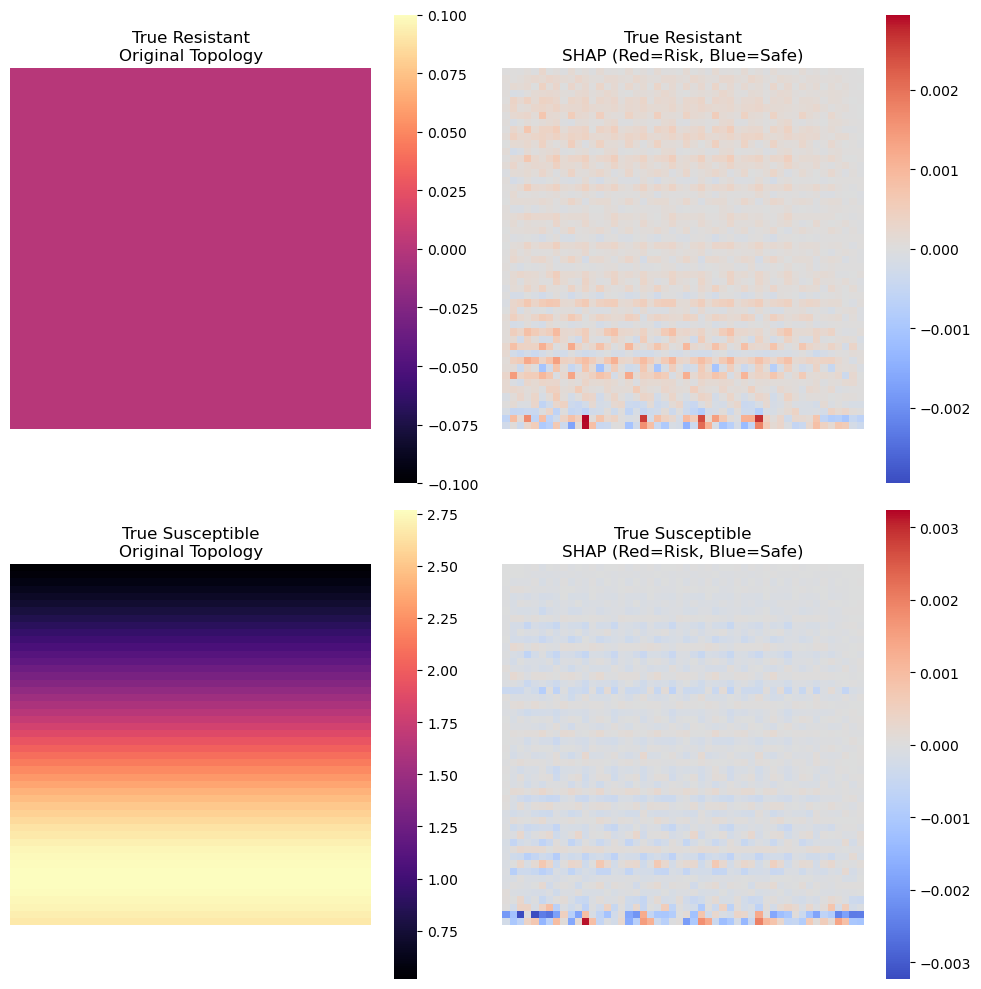

Success! Visualization saved to 'cnn_shap_explanation_fixed.png'


In [221]:
# --- RE-BUILD CNN & GENERATE SHAP EXPLANATION ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

print("Restoring CNN Model for SHAP Analysis...")

# 1. SETUP: Load Data & Shape for CNN
# ---------------------------------------------------------
try:
    df = pd.read_csv("AMR_training_data_2000km_TDA.csv")
    df.columns = df.columns.str.strip()
    
    # Extract & Sort Features
    feature_cols = [c for c in df.columns if c.startswith('tda_pi_')]
    feature_cols.sort(key=lambda x: int(x.split('_')[-1]))
    
    X = df[feature_cols].values.astype(np.float32)
    y = df['Present'].values.astype(np.float32)
    
    # CRITICAL: Reshape for CNN (N, 1, 50, 50)
    X = X.reshape(-1, 1, 50, 50)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # PyTorch Setup
    device = torch.device("cpu") # CPU is fine/safer for SHAP
    
    class TdaImageDataset(Dataset):
        def __init__(self, images, labels):
            self.images = torch.tensor(images)
            self.labels = torch.tensor(labels).unsqueeze(1)
        def __len__(self): return len(self.labels)
        def __getitem__(self, idx): return self.images[idx], self.labels[idx]

    train_loader = DataLoader(TdaImageDataset(X_train, y_train), batch_size=32, shuffle=True)

except Exception as e:
    print(f"Data Error: {e}")
    raise

# 2. MODEL: Re-Define CNN Architecture
# ---------------------------------------------------------
class PersistenceCNN(nn.Module):
    def __init__(self):
        super(PersistenceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x)) # No dropout for SHAP stability
        x = self.sigmoid(self.fc2(x))
        return x

# 3. TRAIN: Quick Retrain
# ---------------------------------------------------------
print("Training CNN...")
model = PersistenceCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model.train()
for epoch in range(20): # 20 epochs is enough for this demo
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()

# 4. EXPLAIN: Run SHAP
# ---------------------------------------------------------
print("Generating SHAP Explanations...")
model.eval()

# Background data (100 samples)
background = torch.tensor(X_train[:100]).to(device)
explainer = shap.DeepExplainer(model, background)

# Find one Resistant (TP) and one Susceptible (TN) to explain
test_tensor = torch.tensor(X_test).to(device)
preds = model(test_tensor).detach().cpu().numpy().flatten()
tp_idx = np.where((preds > 0.5) & (y_test == 1))[0]
tn_idx = np.where((preds < 0.5) & (y_test == 0))[0]

if len(tp_idx) > 0 and len(tn_idx) > 0:
    indices = [tp_idx[0], tn_idx[0]]
    images_to_explain = test_tensor[indices]
    labels = ["True Resistant", "True Susceptible"]
    
    # Calculate SHAP
    shap_values = explainer.shap_values(images_to_explain)
    
    # Handle list return type if necessary
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(2):
        # Original Image
        orig = images_to_explain[i].cpu().numpy().reshape(50, 50)
        sns.heatmap(orig, cmap='magma', ax=axes[i, 0], square=True, cbar=True)
        axes[i, 0].set_title(f"{labels[i]}\nOriginal Topology")
        axes[i, 0].axis('off')
        
        # SHAP Heatmap
        shap_img = shap_values[i].reshape(50, 50)
        limit = np.max(np.abs(shap_img))
        sns.heatmap(shap_img, cmap='coolwarm', center=0, vmin=-limit, vmax=limit, 
                    ax=axes[i, 1], square=True, cbar=True)
        axes[i, 1].set_title(f"{labels[i]}\nSHAP (Red=Risk, Blue=Safe)")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.savefig("cnn_shap_explanation_fixed.png")
    plt.show()
    print("Success! Visualization saved to 'cnn_shap_explanation_fixed.png'")
else:
    print("Could not find suitable True Positive/True Negative examples in this batch.")